## A model build using TweetBERT to classify tweet as causal or non-causal 

The causal sentence prediction model will be trained in several steps using an active learning approach, where in each step the training dataset will be augmented.
In each step the causal sentence classifier is trained and applied on a subsample of unlabeled tweets to identify tweets with causal elements. Those tweets are then manually labeled for the two tasks: causal sentence prediction and cause-effect identification (NER). The newly labeled data will be added to the training dataset and the causal sentence classifier will be retrained with the augmented dataset to increase performance

In [1]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, SubsetRandomSampler
import transformers
from tqdm import tqdm, trange
import io
from utils import normalizeTweet, split_into_sentences, EarlyStopping
import matplotlib.pyplot as plt

########################### Check if cuda available ############################
# print("Cuda available: ", torch.cuda.is_available())
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



########################### DATA FILE ###################################
# dataPath = "/home/adrian/workspace/causality/Causal-associations-diabetes-twitter/data/Causality_tweets_data.xlsx"
dataPath = "data/Causality_tweets_data.xlsx"
#dataPath = "Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
active_learning_round = 4 # will change the saved model name 
lr = 1e-3    
adam_eps = 1e-8
epochs = 35
num_warmup_steps = 0
early_patience = 7# how long to wait after last time validation loss improved

train_batch_size = 16
val_batch_size = 16
test_batch_size = 16
test_to_train_ratio = 0.1 # 10% test and 90% train
val_to_train_ratio = 0.2

metrics_average = "binary" # this will give measure for class_1,i.e., causal class
#
# saveModelName = "./model-causal-model/model_1_finetuned-{}-epochs-lr_{}.pth".format(epochs, lr) # it should be epoch so that the name shows at what epoch teh mdel ws saved
finetuned_model = "./model-causal-model/model_3_finetuned-5-epochs-lr_0.001.pth" # load finetuned model from previous round to continue fine-tuning on new data

#### Checking if thec cuda is available and then select the `gpu`

In [2]:
########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Selected {} for this notebook".format(device))

Cuda available:  True
Selected cuda:0 for this notebook


In [3]:
##### DATA TO LOAD ######

data_round0 = pd.read_excel(dataPath, sheet_name="round0")
data_round0 = data_round0[data_round0["Causal association"].notnull()] # some tweets at the end are not labeled yet
data_round0 = data_round0[["full_text", "Intent", "Cause", "Effect", "Causal association"]]
print("Data round 0 (tweets!):")
print(data_round0["Causal association"].value_counts())
print("-----"*5)


##### additional data labeled through active learning strategy - round 1 ########
data_round1 = pd.read_excel(dataPath, sheet_name="round1")
data_round1 = data_round1[data_round1["Causal association"].notnull()]
data_round1 = data_round1[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round1.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("Sentences round 1:")
print(data_round1["Causal association"].value_counts())
print("-----"*5)

##### additional data labeled through active learning strategy - round 2 ########
data_round2 = pd.read_excel(dataPath, sheet_name="round2")
data_round2 = data_round2[data_round2["Causal association"].notnull()]
data_round2 = data_round2[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round2.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("sentences round 2:")
print(data_round2["Causal association"].value_counts())
print("-----"*5)

##### additional data labeled through active learning strategy - round 3 ########
#data_round3 = pd.read_excel(dataPath, sheet_name="round3")
#data_round3 = data_round3[data_round3["Causal association"].notnull()]
#data_round3 = data_round3[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
#data_round3.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
#print("sentences round 3:")
#print(data_round3["Causal association"].value_counts())
#print("-----"*5)

#### merge datasets ######
data_old = data_round0.append(data_round1).append(data_round2)#.append(data_round3)
print("\nAfter merge old data:")
print(data_old["Causal association"].value_counts())
data_old.head()
print("-----"*5)

##### new additional data labeled through active learning strategy - round 4 (model is only retrained with this data) #####################
data_round4 = pd.read_excel(dataPath, sheet_name="round4")
data_round4 = data_round4[data_round4["Causal association"].notnull()]
data_round4 = data_round4[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round4.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
data_new = data_round4
print("sentences round 4:")
print(data_new["Causal association"].value_counts())

print("----"*5)
print("\n 0:non causal tweet \n 1: causal tweet.\n \n each tweet may have more than one sentence and we are splitting them and labelling by checking if cause or effect occur in them or not")

Data round 0 (tweets!):
0.0    3710
1.0    1290
Name: Causal association, dtype: int64
-------------------------
Sentences round 1:
0.0    1763
1.0     429
Name: Causal association, dtype: int64
-------------------------
sentences round 2:
0    1658
1     150
Name: Causal association, dtype: int64
-------------------------

After merge old data:
0.0    7131
1.0    1869
Name: Causal association, dtype: int64
-------------------------
sentences round 4:
0    1895
1     313
Name: Causal association, dtype: int64
--------------------

 0:non causal tweet 
 1: causal tweet.
 
 each tweet may have more than one sentence and we are splitting them and labelling by checking if cause or effect occur in them or not


### Preprocessing

In [4]:
def get_start_end_index_of_sentence_in_tweet(tweet, sentence):
    """ 
    The sentence tokens are included in the tweet tokens.
    Return the start end end indices of the sentence tokens in the tweet tokens

    """

    sentence_start_word = sentence[0]
    start_indices = [i for i, x in enumerate(tweet) if x == sentence_start_word] # find all indices of the start word of the sentence 
    try:
        for start_index in start_indices:
            isTrueStartIndex = all([tweet[start_index+i] == sentence[i] for i in range(len(sentence))])
            #print("start_index:", start_index, "isTrueStartIndex:", isTrueStartIndex)
            if isTrueStartIndex:
                return start_index, start_index + len(sentence) 
    except:
        print("ERROR: StartIndex should have been found for sentence:")
        print("tweet:")
        print(tweet)
        print("sentence:")
        print(sentence)
    return -1, -2 # should not be returned


def split_tweets_to_sentences(data):
    """ 
        Splits tweets into sentences and associates the appropriate intent, causes, effects and causal association
        to each sentence.
        
        Parameters:
        - min_words_in_sentences: Minimal number of words in a sentence such that the sentence is kept. 
                                  Assumption: A sentence with too few words does not have enough information
                              
                              
                              
        Ex.:
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what? type 1 causes insulin dependence | q;msS  | type 1|insulin dependence | 1       | ...  
        
        New dataframe returned: 
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what?                                  |   q    |       |        |       0            | ...
        type 1 causes insulin dependence       |        | type 1| insulin dependence | 1       | ...  
    """

    newDF = pd.DataFrame(columns=["sentence", "Intent", "Cause", "Effect", "Causal association", "tokenized"])
    
    for i,row in data.iterrows():
        causes = row["Cause"]
        effects = row["Effect"]
        sentences = split_into_sentences(normalizeTweet(row["full_text"]))
        
        # single sentence in tweet
        if len(sentences) == 1:
            singleSentenceIntent = ""
            if isinstance(row["Intent"], str):
                if len(row["Intent"].split(";")) > 1:
                    singleSentenceIntent = row["Intent"].strip().replace(";msS", "").replace("msS;", "").replace(";mS", "").replace("mS;", "")
                else:
                    if row["Intent"] == "mS" or row["Intent"] == "msS":
                        singleSentenceIntent = ""
                    else:
                        singleSentenceIntent = row["Intent"].strip()
                    
            newDF=newDF.append(pd.Series({"sentence": sentences[0] # only one sentence
                         , "Intent": singleSentenceIntent
                         , "Cause" : row["Cause"]
                         , "Effect": row["Effect"]
                         , "Causal association" : row["Causal association"]
                         , "tokenized": row["tokenized"]}), ignore_index=True)
        
        # tweet has several sentences
        else: 
            intents = str(row["Intent"]).strip().split(";")
            for sentence in sentences:
                sent_tokenized = sentence.split(" ")
                causeInSentence = np.nan if not isinstance(causes, str) or not any([cause in sentence for cause in causes.split(";")]) else ";".join([cause for cause in causes.split(";") if cause in sentence])
                effectInSentence = np.nan if not isinstance(effects, str) or not any([effect in sentence for effect in effects.split(";")]) else ";".join([effect for effect in effects.split(";") if effect in sentence])
                causalAssociationInSentence = 1 if isinstance(causeInSentence, str) and isinstance(effectInSentence, str) else 0
                startIndex, endIndex = get_start_end_index_of_sentence_in_tweet(row["tokenized"], sent_tokenized)
                sentence_tokenized = row["tokenized"][startIndex:endIndex]
                
                if "q" in intents and sentence[-1] == "?": # if current sentence is question
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "q", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                    
                elif "joke" in intents: # all sentences with "joke" in tweet keep the intent "joke"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "joke", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)   
                elif "neg" in intents: # all sentences with "neg" in tweet keep intent "neg"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "neg", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)               
                elif isinstance(causeInSentence, str) and isinstance(effectInSentence, str): # cause effect sentence
                    causalIntent = ""
                    if len(causeInSentence.split(";")) > 1:
                        causalIntent = "mC"
                        if len(effectInSentence.split(";")) > 1:
                            causalIntent = "mC;mE"
                    elif len(effectInSentence.split(";")) > 1:
                        causalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": causalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                                  
                else:
                    nonCausalIntent = ""
                    if isinstance(causeInSentence, str): # only cause is given
                        if len(causeInSentence.split(";")) > 1:
                            nonCausalIntent = "mC"
                    elif isinstance(effectInSentence, str): # only effect is given
                        if len(effectInSentence.split(";")) > 1:
                            nonCausalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": nonCausalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)

    return newDF

In [5]:
### Split tweets into sentences (train classifier on sentence level) ####

print("Count of  tweets old:", data_old.shape[0])
print("Count of  tweets new:", data_new.shape[0])

data_old["tokenized"] = data_old["full_text"].map(lambda tweet: normalizeTweet(tweet).split(" "))
dataSentences_old = split_tweets_to_sentences(data_old)
print("Count of sentences old:", dataSentences_old.shape[0])


data_new["tokenized"] = data_new["full_text"].map(lambda tweet: normalizeTweet(tweet).split(" "))
dataSentences_new = split_tweets_to_sentences(data_new)
print("Count of sentences new:", dataSentences_new.shape[0])
dataSentences_new.head()

Count of  tweets old: 9000
Count of  tweets new: 2208
Count of sentences old: 15756
Count of sentences new: 2208


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,my fucking diabetes pod keeps fucking beeping ...,mE,diabetes pod,beeping;loud,1,"[my, fucking, diabetes, pod, keeps, fucking, b..."
1,My life now is like a survivor game and I do n...,,NaN,NaN,0,"[My, life, now, is, like, a, survivor, game, a..."
2,If someone is describing themselves it ' s OK ...,,NaN,NaN,0,"[If, someone, is, describing, themselves, it, ..."
3,"@USER Yeah , they ' ve said my glucose test ca...",,glucose test,diabetic checks,1,"[@USER, Yeah, ,, they, ', ve, said, my, glucos..."
4,"@USER I hope Boris Dildo Johnson , does not fu...",,NaN,NaN,0,"[@USER, I, hope, Boris, Dildo, Johnson, ,, doe..."


In [6]:
########## Remove sentences with joke, question, negation and keep only sentences with more than 3 tokens #####

print("Count ofsentences old before filtering: ", dataSentences_old.shape[0])
dataSentFiltered_old = dataSentences_old[~dataSentences_old["Intent"].str.contains("neg|joke|q")] 
dataSentFiltered_old = dataSentFiltered_old[dataSentFiltered_old["tokenized"].map(len) > 3] 
print("Count of sentences old after filtering: ", dataSentFiltered_old.shape[0])
print("\n")
print("Distribution old:")
print(dataSentFiltered_old["Causal association"].value_counts())
print("----"*5)

print("Count of sentences new before filtering: ", dataSentences_new.shape[0])
dataSentFiltered_new = dataSentences_new[~dataSentences_new["Intent"].str.contains("neg|joke|q")] 
dataSentFiltered_new = dataSentFiltered_new[dataSentFiltered_new["tokenized"].map(len) > 3] 
print("Count of sentences new after filtering: ", dataSentFiltered_new.shape[0])
print("Distribution new:")
print("\n")
print(dataSentFiltered_new["Causal association"].value_counts())
dataSentFiltered_new.head()



Count ofsentences old before filtering:  15756
Count of sentences old after filtering:  12229


Distribution old:
0.0    10625
1.0     1604
Name: Causal association, dtype: int64
--------------------
Count of sentences new before filtering:  2208
Count of sentences new after filtering:  2190
Distribution new:


0    1884
1     306
Name: Causal association, dtype: int64


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,my fucking diabetes pod keeps fucking beeping ...,mE,diabetes pod,beeping;loud,1,"[my, fucking, diabetes, pod, keeps, fucking, b..."
1,My life now is like a survivor game and I do n...,,NaN,NaN,0,"[My, life, now, is, like, a, survivor, game, a..."
2,If someone is describing themselves it ' s OK ...,,NaN,NaN,0,"[If, someone, is, describing, themselves, it, ..."
3,"@USER Yeah , they ' ve said my glucose test ca...",,glucose test,diabetic checks,1,"[@USER, Yeah, ,, they, ', ve, said, my, glucos..."
4,"@USER I hope Boris Dildo Johnson , does not fu...",,NaN,NaN,0,"[@USER, I, hope, Boris, Dildo, Johnson, ,, doe..."


### Data split and calculate class weight

In [7]:
####################### Stratified splits ####################


## ONLY FOR TESTING ---------------
#dataSentFiltered = dataSentFiltered[0:500] # for testing

text_old = dataSentFiltered_old["sentence"].map(normalizeTweet).values.tolist()
labels_old = dataSentFiltered_old["Causal association"].values.tolist()

# first split the data into training and testing label in the ratio of 90:10
train_texts_old, test_texts, train_labels_old, test_labels = train_test_split(text_old, labels_old, test_size=test_to_train_ratio, stratify=labels_old, random_state=9)
train_texts_old, val_texts, train_labels_old, val_labels = train_test_split(train_texts_old, train_labels_old, test_size=val_to_train_ratio, stratify=train_labels_old, random_state=9)

# Redefine training set:Take only new labeled tweets from round 3 for training; test and val set come from old data
train_texts = dataSentFiltered_new["sentence"].map(normalizeTweet).values.tolist()
train_labels = dataSentFiltered_new["Causal association"].values.tolist()

labels = train_labels + val_labels +test_labels # combining new train with validataion and test data from previous rounds


data_count_info = pd.Series(labels).value_counts(normalize=True)
train_count_info = pd.Series(train_labels).value_counts(normalize=True)
val_count_info = pd.Series(val_labels).value_counts(normalize=True)
test_count_info = pd.Series(test_labels).value_counts(normalize=True)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_count_info obtained above has fraction of samples
# for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_count_info)/len(train_count_info)

print("All: Count = {}, % of 0 = {}, % of 1 = {}".format(len(labels), *data_count_info.round(4).to_list()))
print("\n")
print("Train: Count = {}, % of 0 = {}, % of 1 = {}".format(len(train_labels), *train_count_info.round(4).to_list()))
print("\n")
print("Val: Count = {}, % of 0 = {}, % of 1 = {}".format(len(val_labels), *val_count_info.round(4).to_list()))
print("\n")
print("Test: Count = {}, % of 0 = {}, % of 1 = {}".format(len(test_labels), *test_count_info.round(4).to_list()))
print("\n")
print("Balancing class wts: for 0 = {}, for 1 = {}".format(*class_weight.round(4).to_list()))
print("\n")




All: Count = 5615, % of 0 = 0.8655, % of 1 = 0.1345


Train: Count = 2190, % of 0 = 0.8603, % of 1 = 0.1397


Val: Count = 2202, % of 0 = 0.8688, % of 1 = 0.1312


Test: Count = 1223, % of 0 = 0.8692, % of 1 = 0.1308


Balancing class wts: for 0 = 0.5812, for 1 = 3.5784




#### Defining our DataLoader 

In [8]:
class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
        }      

    def __len__(self):
        return len(self.labels)

    
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

train_dataset = TweetDataSet(train_texts, train_labels, tokenizer)
val_dataset = TweetDataSet(val_texts, val_labels, tokenizer)
test_dataset = TweetDataSet(test_texts, test_labels, tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# During training: In each epoch one part of the training data will be used as validation set
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2190
2202
1223


### Evaluation Metrics

In [9]:
## we are measuring weighted metrics - as our dataset is imbalanced 
# Calculate metrics for each label, and find their average weighted by support
# (the number of true instances for each label). 
# This alters ‘macro’ to account for label imbalance; 
# it can result in an F-score that is not between precision and recall.


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

def compute_metrics(pred, labels):
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted')
    precision, recall, f1, _ = precision_recall_fscore_support(labels,pred, average=metrics_average)
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



### Model defintion

In [10]:


class CausalityBERT(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalityBERT, self).__init__()
        self.num_labels = 2
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token        
        output_2 = self.dropout(output_1)
        output_3 = self.linear1(output_2)  
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5

### Moving the model to  GPU and defining training parameters: 
    * num_training_steps 
    * optimizers 
    * scheduler 
    * loss function (weighted) 

In [11]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CausalityBERT() ## just load the model trained in previous round here 
model.load_state_dict(torch.load(finetuned_model, map_location='cpu')) # load model trained in previous round
model.to(device)

# fine-tune only the task-specific parameters
for param in model.bert.parameters():
    param.requires_grad = False

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) # scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0; after a warmup period durnig which it increases linearly from 0 to the initial lr set in the optimizer

## penalising more for class with less number of exaplmes 
loss_fn = CrossEntropyLoss(torch.tensor(class_weight.to_list()).to(device))

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.2.intermediate.dense.bias', 'roberta.encoder.layer.9.output.dense.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.encoder.layer.10.output.dense.bias', 'roberta.encoder.layer.3.attention.self.query.weight', 'roberta.encoder.layer.7.output.dense.bias', 'roberta.encoder.layer.4.attention.self.query.bias', 'roberta.encoder.layer.5.intermediate.dense.weight', 'roberta.encoder.layer.6.intermediate.dense.bias', 'roberta.encoder.layer.2.attention.self.value.weight', 'roberta.encoder.layer.11.intermediate.dense.weight', 'roberta.encoder

### Training (fine-tuning) with Validation and early stopping 

In [13]:
############ TRAINING #############

# initialise the early_stopping object
# early_stopping = EarlyStopping(patience=early_patience, path=saveModelName, verbose=True)
early_stopping = EarlyStopping(patience=early_patience,verbose=True)


train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0


for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")
    
    
    ########### training eval metrics #############################
    train_accuracy = []
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    ###################################################
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        ###########################################################################
        model.train()
        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass
        #############################################################################
        loss = loss_fn(logits, labels)
        print("loss:", loss)
        loss.backward() # backward pass
        optim.step()    # update parameters and take a step up using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
        
    
        ############# Training Accuracy Measure ###################################

        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        metrics = compute_metrics(pred_flat, labels_flat)        
        
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
        
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))
    print(F'\n\tTrain loss: {np.mean(train_loss)}')
    print(F'\n\ttrain acc: {np.mean(train_acc)}')
    print(F'\n\ttraining prec: {np.mean(train_prec)}')
    print(F'\n\ttraining rec: {np.mean(train_rec)}')
    print(F'\n\ttraining f1: {np.mean(train_f1)}')
    
    n_trained_epochs += 1
    
    ###################################################################################

    
    ## ---- Validation ------
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []
    
    
    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader
        
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            ##################################################################################
            model.eval()
            logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 

                        
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        
        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        metrics = compute_metrics(pred_flat, labels_flat)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])

    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))
    print(F'\n\tValidation loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    saveModelName = "./model-causal-model/model_{}_finetuned-{}-epochs-lr_{}.pth".format(active_learning_round,n_trained_epochs-early_patience, lr) 
    early_stopping.path = saveModelName
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>



  1%|          | 1/137 [00:02<06:16,  2.77s/it]

loss: tensor(0.5479, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|▏         | 2/137 [00:04<05:30,  2.45s/it]

loss: tensor(0.5572, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 3/137 [00:07<05:09,  2.31s/it]

loss: tensor(0.8281, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 4/137 [00:09<04:59,  2.26s/it]

loss: tensor(0.4256, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 5/137 [00:11<04:52,  2.22s/it]

loss: tensor(0.3502, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 6/137 [00:13<04:50,  2.21s/it]

loss: tensor(0.5114, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 7/137 [00:15<04:43,  2.18s/it]

loss: tensor(0.7385, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 8/137 [00:17<04:40,  2.17s/it]

loss: tensor(0.7192, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 9/137 [00:20<04:40,  2.19s/it]

loss: tensor(0.5271, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 10/137 [00:22<04:36,  2.18s/it]

loss: tensor(0.3638, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 11/137 [00:24<04:33,  2.17s/it]

loss: tensor(0.6989, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 12/137 [00:26<04:30,  2.16s/it]

loss: tensor(0.6695, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 13/137 [00:28<04:33,  2.21s/it]

loss: tensor(0.1893, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 14/137 [00:31<04:32,  2.22s/it]

loss: tensor(0.9146, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 15/137 [00:33<04:31,  2.22s/it]

loss: tensor(0.4754, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/137 [00:35<04:31,  2.24s/it]

loss: tensor(0.6274, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 17/137 [00:37<04:25,  2.21s/it]

loss: tensor(0.8582, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 18/137 [00:39<04:20,  2.19s/it]

loss: tensor(0.4114, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 19/137 [00:42<04:16,  2.17s/it]

loss: tensor(0.7134, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 20/137 [00:44<04:15,  2.18s/it]

loss: tensor(0.8050, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 21/137 [00:46<04:11,  2.16s/it]

loss: tensor(0.4094, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 22/137 [00:48<04:07,  2.15s/it]

loss: tensor(0.5199, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 23/137 [00:50<04:07,  2.17s/it]

loss: tensor(0.4677, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 24/137 [00:52<04:04,  2.16s/it]

loss: tensor(0.4139, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 25/137 [00:55<04:01,  2.16s/it]

loss: tensor(0.6406, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 26/137 [00:57<03:58,  2.15s/it]

loss: tensor(0.6505, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 27/137 [00:59<03:57,  2.16s/it]

loss: tensor(0.4385, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 28/137 [01:01<03:54,  2.15s/it]

loss: tensor(0.6535, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 29/137 [01:03<03:51,  2.14s/it]

loss: tensor(0.6980, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 30/137 [01:05<03:51,  2.17s/it]

loss: tensor(0.8922, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 31/137 [01:07<03:48,  2.15s/it]

loss: tensor(0.7161, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 32/137 [01:10<03:45,  2.15s/it]

loss: tensor(0.7248, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 33/137 [01:12<03:42,  2.14s/it]

loss: tensor(0.4686, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 34/137 [01:14<03:42,  2.16s/it]

loss: tensor(0.3912, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 35/137 [01:16<03:39,  2.15s/it]

loss: tensor(0.6328, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 36/137 [01:18<03:37,  2.16s/it]

loss: tensor(0.4999, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 37/137 [01:20<03:38,  2.18s/it]

loss: tensor(0.4054, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 38/137 [01:23<03:35,  2.17s/it]

loss: tensor(0.4489, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 39/137 [01:25<03:31,  2.16s/it]

loss: tensor(0.5078, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 40/137 [01:27<03:28,  2.15s/it]

loss: tensor(0.3723, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|██▉       | 41/137 [01:29<03:27,  2.17s/it]

loss: tensor(0.5465, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 42/137 [01:31<03:24,  2.15s/it]

loss: tensor(0.5582, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 43/137 [01:33<03:21,  2.15s/it]

loss: tensor(0.6296, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 44/137 [01:36<03:21,  2.17s/it]

loss: tensor(0.4368, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 45/137 [01:38<03:18,  2.16s/it]

loss: tensor(0.7427, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 46/137 [01:40<03:15,  2.15s/it]

loss: tensor(0.6371, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 47/137 [01:42<03:12,  2.14s/it]

loss: tensor(0.6044, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 48/137 [01:44<03:12,  2.16s/it]

loss: tensor(0.3205, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 49/137 [01:46<03:09,  2.16s/it]

loss: tensor(0.6078, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 50/137 [01:48<03:07,  2.15s/it]

loss: tensor(0.8991, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 51/137 [01:51<03:07,  2.18s/it]

loss: tensor(0.2743, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 52/137 [01:53<03:03,  2.16s/it]

loss: tensor(0.8535, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▊      | 53/137 [01:55<03:03,  2.18s/it]

loss: tensor(0.8099, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 54/137 [01:57<03:02,  2.20s/it]

loss: tensor(0.4414, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 55/137 [02:00<03:03,  2.24s/it]

loss: tensor(0.4419, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 56/137 [02:02<03:01,  2.24s/it]

loss: tensor(0.6510, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 57/137 [02:04<02:59,  2.24s/it]

loss: tensor(0.3573, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 58/137 [02:06<02:59,  2.28s/it]

loss: tensor(1.4905, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 59/137 [02:09<02:54,  2.24s/it]

loss: tensor(0.5707, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 60/137 [02:11<02:50,  2.22s/it]

loss: tensor(0.5514, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 61/137 [02:13<02:46,  2.19s/it]

loss: tensor(0.5282, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 62/137 [02:15<02:44,  2.19s/it]

loss: tensor(0.3751, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 63/137 [02:17<02:40,  2.17s/it]

loss: tensor(0.4543, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 64/137 [02:19<02:37,  2.16s/it]

loss: tensor(0.4055, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 65/137 [02:22<02:36,  2.17s/it]

loss: tensor(0.5364, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 66/137 [02:24<02:33,  2.16s/it]

loss: tensor(0.4575, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 67/137 [02:26<02:30,  2.15s/it]

loss: tensor(0.7587, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 68/137 [02:28<02:27,  2.14s/it]

loss: tensor(0.5974, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 69/137 [02:30<02:27,  2.16s/it]

loss: tensor(0.8003, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 70/137 [02:32<02:23,  2.15s/it]

loss: tensor(0.9039, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 71/137 [02:34<02:21,  2.15s/it]

loss: tensor(0.3506, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 72/137 [02:37<02:20,  2.17s/it]

loss: tensor(0.3742, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 73/137 [02:39<02:17,  2.15s/it]

loss: tensor(0.6858, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 74/137 [02:41<02:14,  2.14s/it]

loss: tensor(0.4876, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 75/137 [02:43<02:12,  2.13s/it]

loss: tensor(0.2982, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 76/137 [02:45<02:11,  2.16s/it]

loss: tensor(0.5397, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 77/137 [02:47<02:08,  2.14s/it]

loss: tensor(0.5816, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 78/137 [02:49<02:05,  2.13s/it]

loss: tensor(0.4972, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 79/137 [02:52<02:04,  2.15s/it]

loss: tensor(0.5393, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 80/137 [02:54<02:01,  2.14s/it]

loss: tensor(0.3431, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 81/137 [02:56<01:59,  2.13s/it]

loss: tensor(0.4855, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 82/137 [02:58<01:56,  2.12s/it]

loss: tensor(1.3192, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 83/137 [03:00<01:55,  2.14s/it]

loss: tensor(0.6682, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 84/137 [03:02<01:52,  2.13s/it]

loss: tensor(0.3094, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 85/137 [03:04<01:50,  2.12s/it]

loss: tensor(0.5509, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 86/137 [03:06<01:49,  2.14s/it]

loss: tensor(0.4175, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 87/137 [03:09<01:46,  2.13s/it]

loss: tensor(0.4018, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 88/137 [03:11<01:44,  2.12s/it]

loss: tensor(0.2905, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 89/137 [03:13<01:41,  2.12s/it]

loss: tensor(0.4265, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 90/137 [03:15<01:40,  2.14s/it]

loss: tensor(0.3906, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 91/137 [03:17<01:38,  2.14s/it]

loss: tensor(0.5474, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 92/137 [03:19<01:36,  2.14s/it]

loss: tensor(0.4424, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 93/137 [03:21<01:34,  2.16s/it]

loss: tensor(0.8444, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 94/137 [03:24<01:32,  2.14s/it]

loss: tensor(0.5761, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 95/137 [03:26<01:29,  2.13s/it]

loss: tensor(0.5674, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 96/137 [03:28<01:27,  2.14s/it]

loss: tensor(1.3107, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 97/137 [03:30<01:26,  2.15s/it]

loss: tensor(0.4215, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 98/137 [03:32<01:23,  2.14s/it]

loss: tensor(0.7163, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 99/137 [03:34<01:21,  2.14s/it]

loss: tensor(0.4446, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 100/137 [03:36<01:20,  2.17s/it]

loss: tensor(0.5568, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 101/137 [03:39<01:17,  2.16s/it]

loss: tensor(0.4527, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 102/137 [03:41<01:15,  2.16s/it]

loss: tensor(0.4206, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 103/137 [03:43<01:13,  2.15s/it]

loss: tensor(0.5202, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 104/137 [03:45<01:11,  2.17s/it]

loss: tensor(1.0733, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 105/137 [03:47<01:09,  2.16s/it]

loss: tensor(0.1927, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 106/137 [03:49<01:06,  2.16s/it]

loss: tensor(0.2989, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 107/137 [03:52<01:05,  2.18s/it]

loss: tensor(0.3810, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 108/137 [03:54<01:03,  2.17s/it]

loss: tensor(0.4100, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 109/137 [03:56<01:00,  2.16s/it]

loss: tensor(0.5222, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 110/137 [03:58<00:57,  2.14s/it]

loss: tensor(0.5949, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 111/137 [04:00<00:56,  2.17s/it]

loss: tensor(0.4358, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 112/137 [04:02<00:53,  2.15s/it]

loss: tensor(0.6222, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 113/137 [04:05<00:51,  2.16s/it]

loss: tensor(0.2819, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 114/137 [04:07<00:50,  2.20s/it]

loss: tensor(0.4111, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 115/137 [04:09<00:48,  2.19s/it]

loss: tensor(0.5466, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 116/137 [04:11<00:46,  2.19s/it]

loss: tensor(0.5282, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 117/137 [04:13<00:43,  2.20s/it]

loss: tensor(0.4545, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 118/137 [04:16<00:42,  2.22s/it]

loss: tensor(0.2722, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 119/137 [04:18<00:39,  2.22s/it]

loss: tensor(0.6002, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 120/137 [04:20<00:37,  2.21s/it]

loss: tensor(0.6987, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 121/137 [04:22<00:35,  2.24s/it]

loss: tensor(0.6720, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 122/137 [04:25<00:33,  2.22s/it]

loss: tensor(0.3757, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 123/137 [04:27<00:31,  2.22s/it]

loss: tensor(0.5533, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 124/137 [04:29<00:28,  2.21s/it]

loss: tensor(0.7890, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 125/137 [04:31<00:26,  2.24s/it]

loss: tensor(0.6897, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 126/137 [04:33<00:24,  2.21s/it]

loss: tensor(1.0973, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 127/137 [04:36<00:22,  2.21s/it]

loss: tensor(0.6384, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 128/137 [04:38<00:20,  2.24s/it]

loss: tensor(0.6750, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 129/137 [04:40<00:17,  2.25s/it]

loss: tensor(0.7017, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 130/137 [04:42<00:15,  2.25s/it]

loss: tensor(0.5838, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 131/137 [04:45<00:13,  2.25s/it]

loss: tensor(0.2535, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 132/137 [04:47<00:11,  2.27s/it]

loss: tensor(0.6701, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 133/137 [04:49<00:09,  2.25s/it]

loss: tensor(0.4356, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 134/137 [04:51<00:06,  2.23s/it]

loss: tensor(0.8114, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 135/137 [04:54<00:04,  2.23s/it]

loss: tensor(0.7673, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 136/137 [04:56<00:02,  2.24s/it]

loss: tensor(1.1158, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 137/137 [04:58<00:00,  2.18s/it]


loss: tensor(0.4707, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.5732071494316533

	train acc: 0.7331856100104275

	training prec: 0.3083146375117178

	training rec: 0.632533889468196

	training f1: 0.3804836282938473



  0%|          | 0/138 [00:00<?, ?it/s]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/138 [00:02<05:05,  2.23s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 2/138 [00:04<04:55,  2.17s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 3/138 [00:06<04:57,  2.20s/it]


	Validation loss: 0.7213675472615422

	Validation acc: 0.5095108695652174

	Validation prec: 0.1987445324401846

	Validation rec: 0.7905797101449274

	Validation f1: 0.3055608240390849
Validation loss decreased (inf --> 0.721368).  Saving model ...


Epoch:   3%|▎         | 1/35 [09:50<5:34:32, 590.36s/it]

<====================== Epoch 2 ======================>



  1%|          | 1/137 [00:02<05:07,  2.26s/it]

loss: tensor(0.6962, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 2/137 [00:04<04:59,  2.22s/it]

loss: tensor(0.4869, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 3/137 [00:06<04:56,  2.21s/it]

loss: tensor(0.3647, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 4/137 [00:08<04:58,  2.24s/it]

loss: tensor(0.5101, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 5/137 [00:11<04:54,  2.23s/it]

loss: tensor(0.5828, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 6/137 [00:13<04:50,  2.22s/it]

loss: tensor(0.3295, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 7/137 [00:15<04:46,  2.20s/it]

loss: tensor(0.5933, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 8/137 [00:17<04:45,  2.22s/it]

loss: tensor(0.4185, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 9/137 [00:19<04:41,  2.20s/it]

loss: tensor(0.2801, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 10/137 [00:22<04:38,  2.19s/it]

loss: tensor(0.2899, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 11/137 [00:24<04:38,  2.21s/it]

loss: tensor(0.7401, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 12/137 [00:26<04:33,  2.19s/it]

loss: tensor(0.8039, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 13/137 [00:28<04:29,  2.17s/it]

loss: tensor(0.7382, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 14/137 [00:30<04:25,  2.16s/it]

loss: tensor(0.2726, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 15/137 [00:32<04:25,  2.18s/it]

loss: tensor(0.7371, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/137 [00:35<04:21,  2.16s/it]

loss: tensor(0.4798, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 17/137 [00:37<04:18,  2.15s/it]

loss: tensor(0.2025, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 18/137 [00:39<04:18,  2.17s/it]

loss: tensor(0.7432, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 19/137 [00:41<04:14,  2.16s/it]

loss: tensor(0.4090, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 20/137 [00:43<04:11,  2.15s/it]

loss: tensor(0.3822, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 21/137 [00:45<04:09,  2.15s/it]

loss: tensor(0.7363, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 22/137 [00:48<04:09,  2.17s/it]

loss: tensor(0.4173, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 23/137 [00:50<04:05,  2.16s/it]

loss: tensor(0.6939, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 24/137 [00:52<04:02,  2.15s/it]

loss: tensor(0.8807, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 25/137 [00:54<04:03,  2.17s/it]

loss: tensor(0.8990, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 26/137 [00:56<03:59,  2.16s/it]

loss: tensor(0.6319, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 27/137 [00:58<03:56,  2.15s/it]

loss: tensor(0.8291, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 28/137 [01:00<03:52,  2.14s/it]

loss: tensor(0.5151, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 29/137 [01:03<03:52,  2.15s/it]

loss: tensor(0.3457, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 30/137 [01:05<03:48,  2.14s/it]

loss: tensor(0.6580, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 31/137 [01:07<03:47,  2.14s/it]

loss: tensor(0.4929, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 32/137 [01:09<03:48,  2.17s/it]

loss: tensor(0.4432, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 33/137 [01:11<03:45,  2.17s/it]

loss: tensor(0.5682, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 34/137 [01:13<03:43,  2.17s/it]

loss: tensor(1.0165, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 35/137 [01:16<03:41,  2.17s/it]

loss: tensor(1.0654, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 36/137 [01:18<03:42,  2.20s/it]

loss: tensor(0.4427, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 37/137 [01:20<03:42,  2.23s/it]

loss: tensor(0.4195, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 38/137 [01:22<03:42,  2.25s/it]

loss: tensor(0.8277, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 39/137 [01:25<03:43,  2.28s/it]

loss: tensor(0.4867, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 40/137 [01:27<03:41,  2.28s/it]

loss: tensor(0.5050, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 41/137 [01:29<03:35,  2.25s/it]

loss: tensor(0.5328, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 42/137 [01:31<03:31,  2.23s/it]

loss: tensor(0.5716, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 43/137 [01:34<03:29,  2.23s/it]

loss: tensor(0.6007, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 44/137 [01:36<03:25,  2.21s/it]

loss: tensor(0.4469, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 45/137 [01:38<03:25,  2.23s/it]

loss: tensor(0.9776, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 46/137 [01:40<03:24,  2.24s/it]

loss: tensor(0.6228, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 47/137 [01:43<03:20,  2.22s/it]

loss: tensor(0.4101, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 48/137 [01:45<03:16,  2.21s/it]

loss: tensor(0.5107, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 49/137 [01:47<03:13,  2.19s/it]

loss: tensor(0.7608, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 50/137 [01:49<03:13,  2.22s/it]

loss: tensor(0.3524, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 51/137 [01:52<03:12,  2.24s/it]

loss: tensor(0.5724, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 52/137 [01:54<03:09,  2.23s/it]

loss: tensor(0.3909, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 53/137 [01:56<03:08,  2.24s/it]

loss: tensor(0.8422, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 54/137 [01:58<03:03,  2.21s/it]

loss: tensor(0.6677, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 55/137 [02:00<02:59,  2.19s/it]

loss: tensor(0.5597, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 56/137 [02:02<02:56,  2.18s/it]

loss: tensor(0.3584, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 57/137 [02:05<02:55,  2.19s/it]

loss: tensor(0.4296, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 58/137 [02:07<02:51,  2.18s/it]

loss: tensor(0.5351, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 59/137 [02:09<02:48,  2.16s/it]

loss: tensor(0.4923, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 60/137 [02:11<02:47,  2.18s/it]

loss: tensor(0.4951, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 61/137 [02:13<02:45,  2.18s/it]

loss: tensor(0.6014, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 62/137 [02:15<02:42,  2.17s/it]

loss: tensor(0.8473, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 63/137 [02:18<02:41,  2.18s/it]

loss: tensor(0.5297, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 64/137 [02:20<02:41,  2.21s/it]

loss: tensor(0.4058, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 65/137 [02:22<02:40,  2.23s/it]

loss: tensor(0.7218, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 66/137 [02:24<02:39,  2.24s/it]

loss: tensor(0.5785, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 67/137 [02:27<02:39,  2.28s/it]

loss: tensor(0.4345, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 68/137 [02:29<02:36,  2.27s/it]

loss: tensor(0.4829, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 69/137 [02:31<02:34,  2.28s/it]

loss: tensor(0.4438, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 70/137 [02:34<02:32,  2.27s/it]

loss: tensor(1.3649, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 71/137 [02:36<02:31,  2.30s/it]

loss: tensor(0.3690, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 72/137 [02:38<02:27,  2.27s/it]

loss: tensor(0.2237, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 73/137 [02:40<02:22,  2.23s/it]

loss: tensor(0.6549, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 74/137 [02:43<02:20,  2.23s/it]

loss: tensor(0.5858, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 75/137 [02:45<02:17,  2.21s/it]

loss: tensor(0.1971, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 76/137 [02:47<02:14,  2.20s/it]

loss: tensor(0.8107, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 77/137 [02:49<02:11,  2.18s/it]

loss: tensor(0.3757, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 78/137 [02:51<02:09,  2.20s/it]

loss: tensor(0.7177, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 79/137 [02:53<02:07,  2.19s/it]

loss: tensor(0.5715, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 80/137 [02:56<02:04,  2.18s/it]

loss: tensor(0.3785, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 81/137 [02:58<02:03,  2.20s/it]

loss: tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 82/137 [03:00<02:00,  2.20s/it]

loss: tensor(0.5852, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 83/137 [03:02<01:58,  2.19s/it]

loss: tensor(0.7488, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 84/137 [03:04<01:55,  2.18s/it]

loss: tensor(0.7977, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 85/137 [03:07<01:54,  2.20s/it]

loss: tensor(0.3103, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 86/137 [03:09<01:51,  2.19s/it]

loss: tensor(0.5599, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 87/137 [03:11<01:49,  2.18s/it]

loss: tensor(0.3805, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 88/137 [03:13<01:47,  2.20s/it]

loss: tensor(1.0154, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 89/137 [03:15<01:45,  2.19s/it]

loss: tensor(0.4385, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 90/137 [03:18<01:42,  2.18s/it]

loss: tensor(0.5693, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 91/137 [03:20<01:40,  2.18s/it]

loss: tensor(0.9541, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 92/137 [03:22<01:39,  2.20s/it]

loss: tensor(0.3662, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 93/137 [03:24<01:36,  2.19s/it]

loss: tensor(0.2010, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 94/137 [03:26<01:33,  2.18s/it]

loss: tensor(0.5763, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 95/137 [03:29<01:32,  2.20s/it]

loss: tensor(0.5245, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 96/137 [03:31<01:30,  2.20s/it]

loss: tensor(0.6628, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 97/137 [03:33<01:27,  2.20s/it]

loss: tensor(0.9316, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 98/137 [03:35<01:25,  2.19s/it]

loss: tensor(1.6269, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 99/137 [03:37<01:24,  2.23s/it]

loss: tensor(0.6808, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 100/137 [03:40<01:22,  2.22s/it]

loss: tensor(0.5467, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 101/137 [03:42<01:19,  2.21s/it]

loss: tensor(0.5887, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 102/137 [03:44<01:17,  2.23s/it]

loss: tensor(0.8126, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 103/137 [03:46<01:14,  2.20s/it]

loss: tensor(0.4550, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 104/137 [03:48<01:11,  2.18s/it]

loss: tensor(0.4372, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 105/137 [03:50<01:09,  2.16s/it]

loss: tensor(0.6280, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 106/137 [03:53<01:07,  2.17s/it]

loss: tensor(0.8401, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 107/137 [03:55<01:04,  2.16s/it]

loss: tensor(0.8456, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 108/137 [03:57<01:02,  2.15s/it]

loss: tensor(0.5375, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 109/137 [03:59<01:00,  2.18s/it]

loss: tensor(0.6548, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 110/137 [04:01<00:58,  2.17s/it]

loss: tensor(0.5920, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 111/137 [04:03<00:56,  2.17s/it]

loss: tensor(0.7170, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 112/137 [04:06<00:54,  2.16s/it]

loss: tensor(0.3738, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 113/137 [04:08<00:52,  2.19s/it]

loss: tensor(0.4027, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 114/137 [04:10<00:50,  2.18s/it]

loss: tensor(0.3875, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 115/137 [04:12<00:47,  2.18s/it]

loss: tensor(0.5770, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 116/137 [04:14<00:46,  2.20s/it]

loss: tensor(0.6730, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 117/137 [04:17<00:43,  2.20s/it]

loss: tensor(0.4250, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 118/137 [04:19<00:41,  2.19s/it]

loss: tensor(0.8344, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 119/137 [04:21<00:39,  2.19s/it]

loss: tensor(0.4725, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 120/137 [04:23<00:37,  2.21s/it]

loss: tensor(0.3870, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 121/137 [04:25<00:35,  2.19s/it]

loss: tensor(0.3877, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 122/137 [04:28<00:32,  2.18s/it]

loss: tensor(0.8646, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 123/137 [04:30<00:30,  2.20s/it]

loss: tensor(0.7032, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 124/137 [04:32<00:28,  2.18s/it]

loss: tensor(0.7178, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 125/137 [04:34<00:26,  2.18s/it]

loss: tensor(0.3623, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 126/137 [04:36<00:23,  2.18s/it]

loss: tensor(1.1171, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 127/137 [04:39<00:21,  2.19s/it]

loss: tensor(0.7130, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 128/137 [04:41<00:19,  2.18s/it]

loss: tensor(0.4272, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 129/137 [04:43<00:17,  2.16s/it]

loss: tensor(0.5028, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 130/137 [04:45<00:15,  2.17s/it]

loss: tensor(0.5119, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 131/137 [04:47<00:12,  2.16s/it]

loss: tensor(0.4609, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 132/137 [04:49<00:10,  2.15s/it]

loss: tensor(0.4156, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 133/137 [04:51<00:08,  2.14s/it]

loss: tensor(0.4618, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 134/137 [04:54<00:06,  2.16s/it]

loss: tensor(0.4075, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 135/137 [04:56<00:04,  2.15s/it]

loss: tensor(1.1284, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 136/137 [04:58<00:02,  2.15s/it]

loss: tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 137/137 [05:00<00:00,  2.19s/it]


loss: tensor(0.3846, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.5865890507715462

	train acc: 0.7293404588112617

	training prec: 0.30445659369017036

	training rec: 0.620246784845325

	training f1: 0.3655218261057678



  0%|          | 0/138 [00:00<?, ?it/s]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/138 [00:02<04:53,  2.15s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 2/138 [00:04<04:45,  2.10s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 3/138 [00:06<04:40,  2.08s/it]


	Validation loss: 0.5623413544634114

	Validation acc: 0.763768115942029

	Validation prec: 0.2928858983206809

	Validation rec: 0.5684782608695651

	Validation f1: 0.36046920068659194
Validation loss decreased (0.721368 --> 0.562341).  Saving model ...


Epoch:   6%|▌         | 2/35 [19:39<5:24:21, 589.73s/it]

<====================== Epoch 3 ======================>



  1%|          | 1/137 [00:02<04:48,  2.12s/it]

loss: tensor(0.5860, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 2/137 [00:04<04:48,  2.13s/it]

loss: tensor(0.7149, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 3/137 [00:06<04:51,  2.18s/it]

loss: tensor(0.4852, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 4/137 [00:08<04:47,  2.16s/it]

loss: tensor(0.3336, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 5/137 [00:10<04:43,  2.15s/it]

loss: tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 6/137 [00:12<04:44,  2.17s/it]

loss: tensor(0.4634, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 7/137 [00:15<04:41,  2.16s/it]

loss: tensor(0.4434, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 8/137 [00:17<04:39,  2.16s/it]

loss: tensor(0.4388, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 9/137 [00:19<04:36,  2.16s/it]

loss: tensor(0.9066, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 10/137 [00:21<04:39,  2.20s/it]

loss: tensor(0.3514, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 11/137 [00:23<04:35,  2.18s/it]

loss: tensor(0.5081, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 12/137 [00:26<04:30,  2.17s/it]

loss: tensor(0.5962, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 13/137 [00:28<04:30,  2.18s/it]

loss: tensor(0.8501, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|█         | 14/137 [00:30<04:25,  2.16s/it]

loss: tensor(0.7507, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 15/137 [00:32<04:21,  2.15s/it]

loss: tensor(0.3543, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/137 [00:34<04:18,  2.14s/it]

loss: tensor(0.4500, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 17/137 [00:36<04:18,  2.16s/it]

loss: tensor(0.6739, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 18/137 [00:38<04:14,  2.14s/it]

loss: tensor(0.2700, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 19/137 [00:40<04:11,  2.13s/it]

loss: tensor(0.2742, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 20/137 [00:43<04:11,  2.15s/it]

loss: tensor(0.5178, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 21/137 [00:45<04:09,  2.15s/it]

loss: tensor(0.7904, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 22/137 [00:47<04:06,  2.14s/it]

loss: tensor(0.6484, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 23/137 [00:49<04:03,  2.14s/it]

loss: tensor(0.3269, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 24/137 [00:51<04:04,  2.16s/it]

loss: tensor(0.5968, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 25/137 [00:53<04:01,  2.16s/it]

loss: tensor(0.6661, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 26/137 [00:56<03:58,  2.15s/it]

loss: tensor(0.4953, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 27/137 [00:58<03:58,  2.16s/it]

loss: tensor(0.5404, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 28/137 [01:00<03:54,  2.15s/it]

loss: tensor(0.5913, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 29/137 [01:02<03:51,  2.14s/it]

loss: tensor(0.6954, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 30/137 [01:04<03:49,  2.14s/it]

loss: tensor(0.2665, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 31/137 [01:06<03:49,  2.17s/it]

loss: tensor(0.7252, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 32/137 [01:08<03:46,  2.15s/it]

loss: tensor(0.6833, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 33/137 [01:11<03:43,  2.15s/it]

loss: tensor(0.7985, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 34/137 [01:13<03:43,  2.17s/it]

loss: tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 35/137 [01:15<03:41,  2.17s/it]

loss: tensor(0.5158, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 36/137 [01:17<03:38,  2.17s/it]

loss: tensor(0.5930, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 37/137 [01:19<03:36,  2.17s/it]

loss: tensor(0.7216, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 38/137 [01:22<03:35,  2.18s/it]

loss: tensor(0.8807, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 39/137 [01:24<03:31,  2.16s/it]

loss: tensor(0.6394, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 40/137 [01:26<03:28,  2.15s/it]

loss: tensor(0.4109, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 41/137 [01:28<03:28,  2.17s/it]

loss: tensor(0.6106, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 42/137 [01:30<03:25,  2.16s/it]

loss: tensor(0.5521, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 43/137 [01:32<03:22,  2.15s/it]

loss: tensor(0.4406, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 44/137 [01:34<03:20,  2.15s/it]

loss: tensor(0.6506, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 45/137 [01:37<03:20,  2.18s/it]

loss: tensor(0.7316, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 46/137 [01:39<03:17,  2.17s/it]

loss: tensor(0.5334, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 47/137 [01:41<03:14,  2.16s/it]

loss: tensor(0.4227, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 48/137 [01:43<03:13,  2.18s/it]

loss: tensor(0.7053, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 49/137 [01:45<03:10,  2.17s/it]

loss: tensor(0.7560, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 50/137 [01:47<03:08,  2.16s/it]

loss: tensor(0.5079, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 51/137 [01:50<03:05,  2.15s/it]

loss: tensor(0.7086, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 52/137 [01:52<03:04,  2.17s/it]

loss: tensor(0.5551, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 53/137 [01:54<03:02,  2.17s/it]

loss: tensor(0.6766, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 54/137 [01:56<02:59,  2.16s/it]

loss: tensor(0.6098, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 55/137 [01:58<02:59,  2.19s/it]

loss: tensor(0.6027, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 56/137 [02:01<02:56,  2.18s/it]

loss: tensor(0.5669, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 57/137 [02:03<02:53,  2.17s/it]

loss: tensor(0.7819, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 58/137 [02:05<02:51,  2.16s/it]

loss: tensor(0.5531, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 59/137 [02:07<02:50,  2.18s/it]

loss: tensor(0.4772, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 60/137 [02:09<02:46,  2.17s/it]

loss: tensor(0.4969, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 61/137 [02:11<02:44,  2.16s/it]

loss: tensor(0.3210, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 62/137 [02:14<02:43,  2.18s/it]

loss: tensor(0.7426, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 63/137 [02:16<02:40,  2.17s/it]

loss: tensor(0.5958, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 64/137 [02:18<02:37,  2.16s/it]

loss: tensor(0.3502, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 65/137 [02:20<02:34,  2.15s/it]

loss: tensor(0.3560, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 66/137 [02:22<02:34,  2.17s/it]

loss: tensor(0.7843, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 67/137 [02:24<02:30,  2.15s/it]

loss: tensor(0.6256, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 68/137 [02:26<02:27,  2.14s/it]

loss: tensor(0.6169, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 69/137 [02:29<02:26,  2.16s/it]

loss: tensor(0.7815, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 70/137 [02:31<02:23,  2.14s/it]

loss: tensor(0.4776, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 71/137 [02:33<02:20,  2.13s/it]

loss: tensor(0.7515, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 72/137 [02:35<02:17,  2.12s/it]

loss: tensor(0.6642, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 73/137 [02:37<02:17,  2.14s/it]

loss: tensor(0.3702, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 74/137 [02:39<02:14,  2.13s/it]

loss: tensor(0.5311, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 75/137 [02:41<02:13,  2.16s/it]

loss: tensor(0.4734, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 76/137 [02:44<02:14,  2.21s/it]

loss: tensor(0.3667, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 77/137 [02:46<02:12,  2.22s/it]

loss: tensor(0.4716, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 78/137 [02:48<02:10,  2.21s/it]

loss: tensor(0.7840, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 79/137 [02:50<02:08,  2.21s/it]

loss: tensor(0.3937, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 80/137 [02:53<02:06,  2.22s/it]

loss: tensor(0.6450, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 81/137 [02:55<02:03,  2.20s/it]

loss: tensor(0.4654, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 82/137 [02:57<02:00,  2.19s/it]

loss: tensor(0.3864, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 83/137 [02:59<01:58,  2.20s/it]

loss: tensor(0.5582, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 84/137 [03:01<01:55,  2.18s/it]

loss: tensor(0.2084, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 85/137 [03:03<01:52,  2.16s/it]

loss: tensor(0.3548, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 86/137 [03:06<01:49,  2.15s/it]

loss: tensor(0.4842, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 87/137 [03:08<01:48,  2.17s/it]

loss: tensor(0.4681, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 88/137 [03:10<01:45,  2.16s/it]

loss: tensor(0.2899, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 89/137 [03:12<01:43,  2.15s/it]

loss: tensor(0.4376, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 90/137 [03:14<01:41,  2.17s/it]

loss: tensor(0.4770, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 91/137 [03:16<01:39,  2.16s/it]

loss: tensor(0.5965, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 92/137 [03:19<01:36,  2.15s/it]

loss: tensor(0.6895, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 93/137 [03:21<01:34,  2.14s/it]

loss: tensor(0.8019, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 94/137 [03:23<01:33,  2.17s/it]

loss: tensor(0.5251, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 95/137 [03:25<01:31,  2.17s/it]

loss: tensor(0.3980, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 96/137 [03:27<01:28,  2.16s/it]

loss: tensor(0.4351, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 97/137 [03:29<01:27,  2.18s/it]

loss: tensor(0.4706, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 98/137 [03:32<01:24,  2.16s/it]

loss: tensor(0.2821, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 99/137 [03:34<01:21,  2.15s/it]

loss: tensor(0.7312, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 100/137 [03:36<01:19,  2.14s/it]

loss: tensor(0.6352, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 101/137 [03:38<01:17,  2.16s/it]

loss: tensor(0.5758, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 102/137 [03:40<01:15,  2.15s/it]

loss: tensor(0.6124, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 103/137 [03:42<01:13,  2.16s/it]

loss: tensor(0.5149, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 104/137 [03:45<01:11,  2.18s/it]

loss: tensor(0.4990, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 105/137 [03:47<01:09,  2.16s/it]

loss: tensor(0.1630, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 106/137 [03:49<01:06,  2.15s/it]

loss: tensor(0.8131, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 107/137 [03:51<01:04,  2.14s/it]

loss: tensor(1.3882, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 108/137 [03:53<01:02,  2.17s/it]

loss: tensor(1.1337, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 109/137 [03:55<01:00,  2.15s/it]

loss: tensor(0.7067, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 110/137 [03:57<00:57,  2.15s/it]

loss: tensor(0.3133, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 111/137 [04:00<00:56,  2.16s/it]

loss: tensor(1.1030, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 112/137 [04:02<00:53,  2.15s/it]

loss: tensor(0.4263, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 113/137 [04:04<00:51,  2.15s/it]

loss: tensor(0.3136, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 114/137 [04:06<00:49,  2.16s/it]

loss: tensor(0.5489, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 115/137 [04:08<00:48,  2.19s/it]

loss: tensor(0.4470, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▍ | 116/137 [04:11<00:46,  2.19s/it]

loss: tensor(0.6458, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 117/137 [04:13<00:43,  2.18s/it]

loss: tensor(0.4443, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 118/137 [04:15<00:41,  2.18s/it]

loss: tensor(0.3705, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 119/137 [04:17<00:38,  2.16s/it]

loss: tensor(0.4267, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 120/137 [04:19<00:36,  2.17s/it]

loss: tensor(0.4960, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 121/137 [04:21<00:34,  2.18s/it]

loss: tensor(0.3299, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 122/137 [04:24<00:33,  2.21s/it]

loss: tensor(0.8456, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 123/137 [04:26<00:30,  2.18s/it]

loss: tensor(0.6558, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 124/137 [04:28<00:28,  2.16s/it]

loss: tensor(0.4967, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████ | 125/137 [04:30<00:26,  2.18s/it]

loss: tensor(0.2477, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 126/137 [04:32<00:23,  2.18s/it]

loss: tensor(0.6378, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 127/137 [04:35<00:21,  2.19s/it]

loss: tensor(0.7244, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 128/137 [04:37<00:19,  2.20s/it]

loss: tensor(1.0206, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 129/137 [04:39<00:17,  2.22s/it]

loss: tensor(1.2405, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▍| 130/137 [04:41<00:15,  2.22s/it]

loss: tensor(0.3415, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 131/137 [04:43<00:13,  2.20s/it]

loss: tensor(0.2898, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 132/137 [04:46<00:11,  2.21s/it]

loss: tensor(0.8513, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 133/137 [04:48<00:08,  2.19s/it]

loss: tensor(0.5200, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 134/137 [04:50<00:06,  2.18s/it]

loss: tensor(0.5824, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 135/137 [04:52<00:04,  2.19s/it]

loss: tensor(0.8684, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 136/137 [04:54<00:02,  2.23s/it]

loss: tensor(0.3238, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 137/137 [04:56<00:00,  2.17s/it]


loss: tensor(1.0173, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.5741370323583157

	train acc: 0.7514337851929093

	training prec: 0.31952976058815474

	training rec: 0.6300486618004866

	training f1: 0.3907684057748463



  0%|          | 0/138 [00:00<?, ?it/s]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/138 [00:02<04:42,  2.06s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 2/138 [00:04<04:40,  2.06s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 3/138 [00:06<04:49,  2.15s/it]


	Validation loss: 0.5933046161696531

	Validation acc: 0.6041666666666666

	Validation prec: 0.22725181420833593

	Validation rec: 0.7719806763285024

	Validation f1: 0.33697713672138224
EarlyStopping counter: 1 out of 7
<====================== Epoch 4 ======================>



  1%|          | 1/137 [00:02<05:03,  2.23s/it]

loss: tensor(0.4053, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 2/137 [00:04<04:54,  2.18s/it]

loss: tensor(0.8576, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 3/137 [00:06<04:50,  2.16s/it]

loss: tensor(0.6407, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 4/137 [00:08<04:47,  2.16s/it]

loss: tensor(0.6634, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 5/137 [00:10<04:48,  2.19s/it]

loss: tensor(0.7475, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 6/137 [00:13<04:46,  2.19s/it]

loss: tensor(0.5280, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 7/137 [00:15<04:44,  2.19s/it]

loss: tensor(0.8568, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 8/137 [00:17<04:44,  2.20s/it]

loss: tensor(0.5188, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 9/137 [00:19<04:41,  2.20s/it]

loss: tensor(0.5720, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 10/137 [00:21<04:37,  2.18s/it]

loss: tensor(0.7439, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 11/137 [00:24<04:34,  2.18s/it]

loss: tensor(0.3504, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 12/137 [00:26<04:34,  2.19s/it]

loss: tensor(0.5541, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 13/137 [00:28<04:31,  2.19s/it]

loss: tensor(0.4226, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 14/137 [00:30<04:28,  2.18s/it]

loss: tensor(0.5073, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 15/137 [00:32<04:28,  2.20s/it]

loss: tensor(0.5620, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 16/137 [00:34<04:24,  2.19s/it]

loss: tensor(1.3412, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 17/137 [00:37<04:21,  2.18s/it]

loss: tensor(0.8322, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 18/137 [00:39<04:20,  2.19s/it]

loss: tensor(1.0043, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 19/137 [00:41<04:20,  2.20s/it]

loss: tensor(0.6629, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 20/137 [00:43<04:16,  2.19s/it]

loss: tensor(0.5457, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 21/137 [00:46<04:17,  2.22s/it]

loss: tensor(0.6980, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 22/137 [00:48<04:15,  2.22s/it]

loss: tensor(0.5385, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 23/137 [00:50<04:10,  2.20s/it]

loss: tensor(0.8531, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 24/137 [00:52<04:06,  2.18s/it]

loss: tensor(0.5813, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 25/137 [00:54<04:02,  2.17s/it]

loss: tensor(0.6184, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 26/137 [00:56<04:05,  2.21s/it]

loss: tensor(0.4364, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 27/137 [00:59<04:02,  2.21s/it]

loss: tensor(0.6902, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 28/137 [01:01<04:01,  2.22s/it]

loss: tensor(1.0080, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 29/137 [01:03<04:02,  2.25s/it]

loss: tensor(1.3295, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 30/137 [01:05<04:00,  2.24s/it]

loss: tensor(0.8822, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 31/137 [01:08<03:59,  2.26s/it]

loss: tensor(0.5876, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 32/137 [01:10<03:56,  2.26s/it]

loss: tensor(0.6151, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 33/137 [01:12<03:57,  2.28s/it]

loss: tensor(0.4139, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 34/137 [01:15<03:50,  2.24s/it]

loss: tensor(0.4615, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 35/137 [01:17<03:46,  2.22s/it]

loss: tensor(1.4452, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 36/137 [01:19<03:44,  2.22s/it]

loss: tensor(0.3150, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 37/137 [01:21<03:39,  2.20s/it]

loss: tensor(0.5207, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 38/137 [01:23<03:39,  2.22s/it]

loss: tensor(0.5538, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 39/137 [01:25<03:34,  2.19s/it]

loss: tensor(0.5146, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 40/137 [01:28<03:32,  2.19s/it]

loss: tensor(0.5548, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 41/137 [01:30<03:28,  2.17s/it]

loss: tensor(0.3362, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 42/137 [01:32<03:25,  2.16s/it]

loss: tensor(0.5287, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 43/137 [01:34<03:24,  2.17s/it]

loss: tensor(0.6144, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 44/137 [01:36<03:20,  2.16s/it]

loss: tensor(0.7097, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 45/137 [01:38<03:17,  2.15s/it]

loss: tensor(0.6153, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▎      | 46/137 [01:41<03:15,  2.14s/it]

loss: tensor(0.3758, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 47/137 [01:43<03:14,  2.16s/it]

loss: tensor(0.5177, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 48/137 [01:45<03:11,  2.16s/it]

loss: tensor(0.5307, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 49/137 [01:47<03:08,  2.15s/it]

loss: tensor(0.5856, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 50/137 [01:49<03:08,  2.16s/it]

loss: tensor(0.5547, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 51/137 [01:51<03:04,  2.15s/it]

loss: tensor(0.6427, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 52/137 [01:53<03:01,  2.14s/it]

loss: tensor(0.4415, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 53/137 [01:56<02:59,  2.14s/it]

loss: tensor(0.7939, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 54/137 [01:58<02:58,  2.15s/it]

loss: tensor(0.4687, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 55/137 [02:00<02:56,  2.15s/it]

loss: tensor(0.4504, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 56/137 [02:02<02:54,  2.15s/it]

loss: tensor(0.4905, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 57/137 [02:04<02:53,  2.16s/it]

loss: tensor(0.5745, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 58/137 [02:06<02:50,  2.16s/it]

loss: tensor(0.5000, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 59/137 [02:08<02:47,  2.15s/it]

loss: tensor(0.4307, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 60/137 [02:11<02:45,  2.14s/it]

loss: tensor(0.4735, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 61/137 [02:13<02:44,  2.17s/it]

loss: tensor(0.5650, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▌     | 62/137 [02:15<02:42,  2.17s/it]

loss: tensor(0.5794, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 63/137 [02:17<02:40,  2.17s/it]

loss: tensor(0.5506, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 64/137 [02:19<02:39,  2.18s/it]

loss: tensor(0.3980, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 65/137 [02:22<02:35,  2.16s/it]

loss: tensor(1.9368, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 66/137 [02:24<02:32,  2.15s/it]

loss: tensor(0.3922, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 67/137 [02:26<02:29,  2.14s/it]

loss: tensor(0.3349, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 68/137 [02:28<02:29,  2.16s/it]

loss: tensor(0.5053, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 69/137 [02:30<02:25,  2.15s/it]

loss: tensor(0.6623, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 70/137 [02:32<02:23,  2.14s/it]

loss: tensor(0.6494, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 71/137 [02:34<02:22,  2.16s/it]

loss: tensor(0.6296, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 72/137 [02:37<02:19,  2.15s/it]

loss: tensor(0.5276, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 73/137 [02:39<02:16,  2.14s/it]

loss: tensor(0.5112, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 74/137 [02:41<02:14,  2.14s/it]

loss: tensor(0.2593, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 75/137 [02:43<02:13,  2.16s/it]

loss: tensor(0.6335, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 76/137 [02:45<02:10,  2.14s/it]

loss: tensor(0.4488, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 77/137 [02:47<02:08,  2.13s/it]

loss: tensor(0.6990, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 78/137 [02:49<02:06,  2.15s/it]

loss: tensor(0.5191, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 79/137 [02:52<02:04,  2.14s/it]

loss: tensor(0.5187, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 80/137 [02:54<02:01,  2.14s/it]

loss: tensor(0.3060, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 81/137 [02:56<01:59,  2.13s/it]

loss: tensor(0.5777, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 82/137 [02:58<01:58,  2.15s/it]

loss: tensor(0.5624, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 83/137 [03:00<01:55,  2.14s/it]

loss: tensor(0.5029, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 84/137 [03:02<01:53,  2.14s/it]

loss: tensor(0.4534, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 85/137 [03:04<01:52,  2.16s/it]

loss: tensor(0.3008, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 86/137 [03:07<01:49,  2.15s/it]

loss: tensor(0.4573, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 87/137 [03:09<01:46,  2.14s/it]

loss: tensor(0.7349, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 88/137 [03:11<01:45,  2.15s/it]

loss: tensor(0.3316, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 89/137 [03:13<01:44,  2.18s/it]

loss: tensor(0.7125, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 90/137 [03:15<01:42,  2.17s/it]

loss: tensor(0.7607, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 91/137 [03:17<01:39,  2.17s/it]

loss: tensor(0.3455, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 92/137 [03:20<01:38,  2.19s/it]

loss: tensor(0.7210, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 93/137 [03:22<01:35,  2.17s/it]

loss: tensor(0.3086, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 94/137 [03:24<01:32,  2.15s/it]

loss: tensor(0.3348, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 95/137 [03:26<01:30,  2.14s/it]

loss: tensor(0.6193, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 96/137 [03:28<01:28,  2.16s/it]

loss: tensor(0.2750, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 97/137 [03:30<01:25,  2.15s/it]

loss: tensor(0.5954, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 98/137 [03:32<01:23,  2.14s/it]

loss: tensor(0.5737, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 99/137 [03:35<01:22,  2.16s/it]

loss: tensor(0.5458, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 100/137 [03:37<01:19,  2.15s/it]

loss: tensor(0.4171, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 101/137 [03:39<01:17,  2.14s/it]

loss: tensor(0.6373, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 102/137 [03:41<01:14,  2.14s/it]

loss: tensor(0.3750, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 103/137 [03:43<01:13,  2.18s/it]

loss: tensor(0.7762, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 104/137 [03:45<01:11,  2.18s/it]

loss: tensor(0.4311, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 105/137 [03:48<01:09,  2.18s/it]

loss: tensor(0.5689, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 106/137 [03:50<01:08,  2.20s/it]

loss: tensor(0.3828, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 107/137 [03:52<01:05,  2.20s/it]

loss: tensor(0.3602, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 108/137 [03:54<01:03,  2.20s/it]

loss: tensor(0.9304, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 109/137 [03:56<01:01,  2.20s/it]

loss: tensor(0.3934, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|████████  | 110/137 [03:59<00:59,  2.22s/it]

loss: tensor(0.3425, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 111/137 [04:01<00:57,  2.20s/it]

loss: tensor(0.9067, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 112/137 [04:03<00:54,  2.19s/it]

loss: tensor(0.4032, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 113/137 [04:05<00:52,  2.20s/it]

loss: tensor(0.4985, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 114/137 [04:07<00:50,  2.19s/it]

loss: tensor(0.5351, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▍ | 115/137 [04:10<00:47,  2.17s/it]

loss: tensor(0.9042, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 116/137 [04:12<00:45,  2.16s/it]

loss: tensor(0.6976, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 117/137 [04:14<00:43,  2.17s/it]

loss: tensor(0.4666, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 118/137 [04:16<00:40,  2.16s/it]

loss: tensor(0.4311, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 119/137 [04:18<00:38,  2.14s/it]

loss: tensor(0.3858, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 120/137 [04:20<00:36,  2.16s/it]

loss: tensor(0.3348, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 121/137 [04:22<00:34,  2.16s/it]

loss: tensor(0.4355, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 122/137 [04:25<00:32,  2.15s/it]

loss: tensor(0.7317, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 123/137 [04:27<00:30,  2.15s/it]

loss: tensor(0.5256, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 124/137 [04:29<00:28,  2.17s/it]

loss: tensor(0.7395, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 125/137 [04:31<00:25,  2.17s/it]

loss: tensor(0.5229, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 126/137 [04:33<00:23,  2.16s/it]

loss: tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 127/137 [04:35<00:21,  2.17s/it]

loss: tensor(0.6439, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 128/137 [04:38<00:19,  2.18s/it]

loss: tensor(0.5522, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 94%|█████████▍| 129/137 [04:40<00:17,  2.17s/it]

loss: tensor(0.7333, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 130/137 [04:42<00:15,  2.17s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 131/137 [04:44<00:13,  2.19s/it]

loss: tensor(0.5501, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 132/137 [04:46<00:10,  2.17s/it]

loss: tensor(0.3226, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 133/137 [04:48<00:08,  2.15s/it]

loss: tensor(0.3886, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 134/137 [04:51<00:06,  2.18s/it]

loss: tensor(1.1481, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 135/137 [04:53<00:04,  2.18s/it]

loss: tensor(0.7605, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 136/137 [04:55<00:02,  2.18s/it]

loss: tensor(0.4413, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 137/137 [04:57<00:00,  2.17s/it]


loss: tensor(1.1345, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.5905245290185414

	train acc: 0.7305787278415016

	training prec: 0.27359544348595444

	training rec: 0.5773722627737227

	training f1: 0.33627441090944743



  0%|          | 0/138 [00:00<?, ?it/s]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/138 [00:02<04:42,  2.06s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|▏         | 2/138 [00:04<04:47,  2.12s/it]<ip


	Validation loss: 0.567391822087592

	Validation acc: 0.7245471014492754

	Validation prec: 0.27122153209109734

	Validation rec: 0.5859903381642513

	Validation f1: 0.3491962546310372
EarlyStopping counter: 2 out of 7
<====================== Epoch 5 ======================>



  1%|          | 1/137 [00:02<04:50,  2.13s/it]

loss: tensor(0.6192, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 2/137 [00:04<04:48,  2.14s/it]

loss: tensor(0.4777, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 3/137 [00:06<04:50,  2.17s/it]

loss: tensor(0.3588, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 4/137 [00:08<04:45,  2.14s/it]

loss: tensor(0.4876, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 5/137 [00:10<04:41,  2.13s/it]

loss: tensor(0.3460, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 6/137 [00:12<04:38,  2.13s/it]

loss: tensor(0.3796, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 7/137 [00:15<04:39,  2.15s/it]

loss: tensor(0.6503, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 8/137 [00:17<04:37,  2.15s/it]

loss: tensor(0.5660, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 9/137 [00:19<04:34,  2.14s/it]

loss: tensor(0.5997, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 10/137 [00:21<04:34,  2.16s/it]

loss: tensor(0.6728, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 11/137 [00:23<04:31,  2.15s/it]

loss: tensor(0.4073, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 12/137 [00:25<04:28,  2.15s/it]

loss: tensor(0.4785, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 13/137 [00:27<04:25,  2.14s/it]

loss: tensor(0.4367, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 14/137 [00:30<04:26,  2.17s/it]

loss: tensor(0.8294, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 15/137 [00:32<04:23,  2.16s/it]

loss: tensor(0.4102, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/137 [00:34<04:20,  2.15s/it]

loss: tensor(0.6701, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 17/137 [00:36<04:20,  2.17s/it]

loss: tensor(0.4028, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 18/137 [00:38<04:17,  2.16s/it]

loss: tensor(0.5236, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 19/137 [00:40<04:14,  2.15s/it]

loss: tensor(0.4177, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 20/137 [00:43<04:11,  2.15s/it]

loss: tensor(1.1664, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 21/137 [00:45<04:11,  2.17s/it]

loss: tensor(0.4395, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 22/137 [00:47<04:08,  2.16s/it]

loss: tensor(0.5335, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 23/137 [00:49<04:04,  2.15s/it]

loss: tensor(0.4599, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 24/137 [00:51<04:05,  2.17s/it]

loss: tensor(0.3321, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 25/137 [00:53<04:02,  2.16s/it]

loss: tensor(0.3298, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 26/137 [00:56<03:59,  2.16s/it]

loss: tensor(0.4966, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|█▉        | 27/137 [00:58<03:56,  2.15s/it]

loss: tensor(0.4824, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 28/137 [01:00<03:57,  2.18s/it]

loss: tensor(0.5690, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 29/137 [01:02<03:55,  2.18s/it]

loss: tensor(1.0228, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 30/137 [01:04<03:51,  2.16s/it]

loss: tensor(0.7304, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 31/137 [01:06<03:50,  2.18s/it]

loss: tensor(0.2066, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 32/137 [01:09<03:47,  2.16s/it]

loss: tensor(0.7267, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 33/137 [01:11<03:43,  2.15s/it]

loss: tensor(0.6559, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 34/137 [01:13<03:41,  2.15s/it]

loss: tensor(0.5133, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 35/137 [01:15<03:42,  2.18s/it]

loss: tensor(0.5066, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 36/137 [01:17<03:39,  2.18s/it]

loss: tensor(0.5075, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 37/137 [01:19<03:37,  2.18s/it]

loss: tensor(0.3156, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 38/137 [01:22<03:37,  2.20s/it]

loss: tensor(0.5133, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 39/137 [01:24<03:33,  2.18s/it]

loss: tensor(0.5206, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 40/137 [01:26<03:29,  2.16s/it]

loss: tensor(0.7352, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 41/137 [01:28<03:26,  2.15s/it]

loss: tensor(0.3041, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 42/137 [01:30<03:26,  2.17s/it]

loss: tensor(0.4508, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 43/137 [01:32<03:22,  2.16s/it]

loss: tensor(0.6760, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 44/137 [01:35<03:20,  2.15s/it]

loss: tensor(0.4614, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 45/137 [01:37<03:19,  2.17s/it]

loss: tensor(0.3690, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 46/137 [01:39<03:16,  2.16s/it]

loss: tensor(0.4489, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 47/137 [01:41<03:13,  2.15s/it]

loss: tensor(0.6832, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 48/137 [01:43<03:10,  2.14s/it]

loss: tensor(0.8848, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 49/137 [01:45<03:10,  2.16s/it]

loss: tensor(0.5406, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 50/137 [01:47<03:08,  2.16s/it]

loss: tensor(0.5300, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 51/137 [01:50<03:05,  2.16s/it]

loss: tensor(1.0623, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 52/137 [01:52<03:05,  2.19s/it]

loss: tensor(0.3869, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 53/137 [01:54<03:03,  2.19s/it]

loss: tensor(0.8028, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 54/137 [01:56<03:00,  2.18s/it]

loss: tensor(0.5164, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 55/137 [01:58<02:57,  2.16s/it]

loss: tensor(0.5358, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 56/137 [02:01<02:56,  2.18s/it]

loss: tensor(0.2815, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 57/137 [02:03<02:54,  2.18s/it]

loss: tensor(0.6328, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 58/137 [02:05<02:52,  2.18s/it]

loss: tensor(0.4142, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 59/137 [02:07<02:51,  2.20s/it]

loss: tensor(0.4888, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 60/137 [02:09<02:49,  2.20s/it]

loss: tensor(0.4648, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 61/137 [02:12<02:46,  2.19s/it]

loss: tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 62/137 [02:14<02:43,  2.17s/it]

loss: tensor(0.2933, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 63/137 [02:16<02:42,  2.19s/it]

loss: tensor(0.6681, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 64/137 [02:18<02:39,  2.19s/it]

loss: tensor(0.4806, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 65/137 [02:20<02:37,  2.18s/it]

loss: tensor(0.4426, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 66/137 [02:23<02:36,  2.20s/it]

loss: tensor(0.5297, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 67/137 [02:25<02:33,  2.19s/it]

loss: tensor(0.2568, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 68/137 [02:27<02:30,  2.19s/it]

loss: tensor(0.8325, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 69/137 [02:29<02:28,  2.18s/it]

loss: tensor(0.4395, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 70/137 [02:31<02:27,  2.20s/it]

loss: tensor(0.4770, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 71/137 [02:33<02:23,  2.18s/it]

loss: tensor(0.5935, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 72/137 [02:36<02:20,  2.17s/it]

loss: tensor(0.4152, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 73/137 [02:38<02:19,  2.19s/it]

loss: tensor(0.4560, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 74/137 [02:40<02:17,  2.18s/it]

loss: tensor(0.3076, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 75/137 [02:42<02:15,  2.18s/it]

loss: tensor(0.3466, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 76/137 [02:44<02:12,  2.17s/it]

loss: tensor(1.2530, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 77/137 [02:46<02:11,  2.19s/it]

loss: tensor(0.5486, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 78/137 [02:49<02:08,  2.18s/it]

loss: tensor(1.5596, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 79/137 [02:51<02:06,  2.18s/it]

loss: tensor(0.8172, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 80/137 [02:53<02:05,  2.20s/it]

loss: tensor(0.3642, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 81/137 [02:55<02:02,  2.19s/it]

loss: tensor(0.3057, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 82/137 [02:57<01:59,  2.18s/it]

loss: tensor(0.9356, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 83/137 [03:00<01:57,  2.18s/it]

loss: tensor(0.4711, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 84/137 [03:02<01:56,  2.20s/it]

loss: tensor(0.9343, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 85/137 [03:04<01:53,  2.18s/it]

loss: tensor(0.7692, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 86/137 [03:06<01:50,  2.18s/it]

loss: tensor(0.4704, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 87/137 [03:08<01:49,  2.20s/it]

loss: tensor(0.4669, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 88/137 [03:11<01:47,  2.19s/it]

loss: tensor(0.3872, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 89/137 [03:13<01:44,  2.19s/it]

loss: tensor(0.8640, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 90/137 [03:15<01:42,  2.19s/it]

loss: tensor(0.5082, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 91/137 [03:17<01:41,  2.21s/it]

loss: tensor(0.6983, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 92/137 [03:19<01:39,  2.20s/it]

loss: tensor(0.7052, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 93/137 [03:22<01:36,  2.20s/it]

loss: tensor(0.3874, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 94/137 [03:24<01:35,  2.23s/it]

loss: tensor(0.5531, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 95/137 [03:26<01:33,  2.22s/it]

loss: tensor(0.5399, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 96/137 [03:28<01:30,  2.20s/it]

loss: tensor(0.6428, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 97/137 [03:30<01:27,  2.19s/it]

loss: tensor(0.7044, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 98/137 [03:33<01:26,  2.21s/it]

loss: tensor(0.5645, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 99/137 [03:35<01:23,  2.20s/it]

loss: tensor(0.7809, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 100/137 [03:37<01:20,  2.19s/it]

loss: tensor(0.3491, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▎  | 101/137 [03:39<01:19,  2.21s/it]

loss: tensor(0.3617, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 102/137 [03:41<01:16,  2.20s/it]

loss: tensor(0.6198, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 103/137 [03:44<01:14,  2.19s/it]

loss: tensor(0.7882, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 104/137 [03:46<01:12,  2.20s/it]

loss: tensor(0.6526, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 105/137 [03:48<01:11,  2.22s/it]

loss: tensor(0.6856, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 106/137 [03:50<01:08,  2.22s/it]

loss: tensor(0.5166, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 107/137 [03:52<01:06,  2.21s/it]

loss: tensor(0.6250, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 108/137 [03:55<01:04,  2.23s/it]

loss: tensor(0.4739, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 109/137 [03:57<01:02,  2.21s/it]

loss: tensor(0.5178, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 110/137 [03:59<00:59,  2.20s/it]

loss: tensor(0.5497, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 111/137 [04:01<00:56,  2.19s/it]

loss: tensor(0.5117, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 112/137 [04:04<00:55,  2.21s/it]

loss: tensor(0.7215, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 113/137 [04:06<00:52,  2.20s/it]

loss: tensor(0.5175, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 114/137 [04:08<00:50,  2.19s/it]

loss: tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 115/137 [04:10<00:48,  2.21s/it]

loss: tensor(0.5797, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 116/137 [04:12<00:46,  2.20s/it]

loss: tensor(0.5936, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 117/137 [04:14<00:43,  2.19s/it]

loss: tensor(0.4974, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 118/137 [04:17<00:41,  2.19s/it]

loss: tensor(0.5545, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 119/137 [04:19<00:39,  2.21s/it]

loss: tensor(0.5875, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 120/137 [04:21<00:37,  2.20s/it]

loss: tensor(0.5381, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 121/137 [04:23<00:35,  2.20s/it]

loss: tensor(0.4459, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 122/137 [04:26<00:33,  2.23s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 123/137 [04:28<00:31,  2.21s/it]

loss: tensor(0.3864, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 124/137 [04:30<00:28,  2.21s/it]

loss: tensor(0.4592, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 125/137 [04:32<00:26,  2.20s/it]

loss: tensor(0.6290, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 126/137 [04:34<00:24,  2.22s/it]

loss: tensor(0.4104, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 127/137 [04:37<00:22,  2.21s/it]

loss: tensor(0.7844, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 128/137 [04:39<00:19,  2.21s/it]

loss: tensor(0.4417, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 129/137 [04:41<00:17,  2.23s/it]

loss: tensor(0.4860, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 130/137 [04:43<00:15,  2.22s/it]

loss: tensor(0.3276, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 131/137 [04:45<00:13,  2.20s/it]

loss: tensor(0.4662, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 132/137 [04:48<00:10,  2.19s/it]

loss: tensor(0.2574, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 133/137 [04:50<00:08,  2.21s/it]

loss: tensor(0.4720, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 134/137 [04:52<00:06,  2.20s/it]

loss: tensor(0.6127, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 135/137 [04:54<00:04,  2.19s/it]

loss: tensor(0.7306, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▉| 136/137 [04:56<00:02,  2.21s/it]

loss: tensor(0.6516, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 137/137 [04:58<00:00,  2.18s/it]


loss: tensor(0.4401, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.5566067521589516

	train acc: 0.7544968717413973

	training prec: 0.3421356826466315

	training rec: 0.6262773722627737

	training f1: 0.39918909152485793



  0%|          | 0/138 [00:00<?, ?it/s]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/138 [00:02<04:49,  2.11s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 2/138 [00:04<04:47,  2.11s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 3/138 [00:06<04:44,  2.11s/it]


	Validation loss: 0.5927872726882714

	Validation acc: 0.7893115942028985

	Validation prec: 0.32263630089717044

	Validation rec: 0.49070048309178743

	Validation f1: 0.35261674718196456
EarlyStopping counter: 3 out of 7
<====================== Epoch 6 ======================>



  0%|          | 0/137 [00:00<?, ?it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 1/137 [00:02<04:57,  2.18s/it]

loss: tensor(0.7403, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 2/137 [00:04<05:05,  2.26s/it]

loss: tensor(0.6909, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 3/137 [00:06<05:01,  2.25s/it]

loss: tensor(0.3256, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 4/137 [00:09<05:01,  2.26s/it]

loss: tensor(0.6179, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 5/137 [00:11<04:58,  2.26s/it]

loss: tensor(0.4849, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 6/137 [00:13<04:52,  2.23s/it]

loss: tensor(0.9265, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 7/137 [00:15<04:47,  2.21s/it]

loss: tensor(1.1150, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 8/137 [00:17<04:43,  2.20s/it]

loss: tensor(0.4269, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 9/137 [00:20<04:42,  2.21s/it]

loss: tensor(0.7224, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 10/137 [00:22<04:38,  2.19s/it]

loss: tensor(0.7805, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 11/137 [00:24<04:35,  2.19s/it]

loss: tensor(0.5875, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 12/137 [00:26<04:36,  2.22s/it]

loss: tensor(0.6177, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 13/137 [00:28<04:33,  2.21s/it]

loss: tensor(0.7396, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 14/137 [00:30<04:30,  2.20s/it]

loss: tensor(0.6398, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 15/137 [00:33<04:27,  2.19s/it]

loss: tensor(0.5914, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 16/137 [00:35<04:27,  2.21s/it]

loss: tensor(0.5080, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 17/137 [00:37<04:23,  2.20s/it]

loss: tensor(0.2600, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 18/137 [00:39<04:20,  2.19s/it]

loss: tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 19/137 [00:42<04:21,  2.21s/it]

loss: tensor(0.4249, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 20/137 [00:44<04:17,  2.20s/it]

loss: tensor(0.3164, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 21/137 [00:46<04:17,  2.22s/it]

loss: tensor(0.5472, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 22/137 [00:48<04:14,  2.21s/it]

loss: tensor(0.6419, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 23/137 [00:50<04:14,  2.23s/it]

loss: tensor(0.6764, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 24/137 [00:53<04:09,  2.21s/it]

loss: tensor(1.0023, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 25/137 [00:55<04:06,  2.20s/it]

loss: tensor(0.7056, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 26/137 [00:57<04:05,  2.21s/it]

loss: tensor(0.3443, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|█▉        | 27/137 [00:59<04:01,  2.20s/it]

loss: tensor(0.5587, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 20%|██        | 28/137 [01:01<03:58,  2.19s/it]

loss: tensor(0.2572, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 29/137 [01:04<03:57,  2.20s/it]

loss: tensor(0.5336, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 30/137 [01:06<04:00,  2.25s/it]

loss: tensor(0.3857, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 31/137 [01:08<03:59,  2.26s/it]

loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 32/137 [01:11<03:58,  2.27s/it]

loss: tensor(0.3432, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 33/137 [01:13<04:00,  2.31s/it]

loss: tensor(0.2500, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 34/137 [01:15<03:53,  2.27s/it]

loss: tensor(0.4635, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 35/137 [01:17<03:48,  2.24s/it]

loss: tensor(0.6585, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 36/137 [01:19<03:44,  2.22s/it]

loss: tensor(0.4328, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 37/137 [01:22<03:43,  2.24s/it]

loss: tensor(0.3291, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 38/137 [01:24<03:39,  2.22s/it]

loss: tensor(0.5069, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 39/137 [01:26<03:36,  2.21s/it]

loss: tensor(0.2640, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 40/137 [01:28<03:35,  2.22s/it]

loss: tensor(0.5531, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 41/137 [01:31<03:31,  2.20s/it]

loss: tensor(0.4018, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 42/137 [01:33<03:27,  2.19s/it]

loss: tensor(0.6792, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 43/137 [01:35<03:24,  2.18s/it]

loss: tensor(0.4178, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 44/137 [01:37<03:24,  2.20s/it]

loss: tensor(0.6448, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 45/137 [01:39<03:21,  2.19s/it]

loss: tensor(1.2117, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 46/137 [01:41<03:19,  2.19s/it]

loss: tensor(0.8598, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 47/137 [01:44<03:19,  2.21s/it]

loss: tensor(0.5277, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 48/137 [01:46<03:15,  2.20s/it]

loss: tensor(0.3800, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 49/137 [01:48<03:13,  2.20s/it]

loss: tensor(0.5187, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 50/137 [01:50<03:10,  2.19s/it]

loss: tensor(0.6635, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 51/137 [01:53<03:12,  2.23s/it]

loss: tensor(0.5163, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 52/137 [01:55<03:07,  2.20s/it]

loss: tensor(0.6594, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 53/137 [01:57<03:02,  2.18s/it]

loss: tensor(0.8083, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 54/137 [01:59<03:02,  2.19s/it]

loss: tensor(0.6091, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 55/137 [02:01<03:00,  2.21s/it]

loss: tensor(0.4828, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 56/137 [02:04<03:00,  2.23s/it]

loss: tensor(0.4957, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 57/137 [02:06<02:58,  2.23s/it]

loss: tensor(0.6845, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 58/137 [02:08<02:58,  2.27s/it]

loss: tensor(0.5837, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 59/137 [02:10<02:54,  2.24s/it]

loss: tensor(0.3588, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 60/137 [02:12<02:50,  2.22s/it]

loss: tensor(0.3600, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 61/137 [02:15<02:49,  2.23s/it]

loss: tensor(0.4473, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 62/137 [02:17<02:46,  2.22s/it]

loss: tensor(0.6546, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 63/137 [02:19<02:43,  2.20s/it]

loss: tensor(0.5126, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 64/137 [02:21<02:40,  2.20s/it]

loss: tensor(0.5600, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 65/137 [02:24<02:40,  2.23s/it]

loss: tensor(0.5384, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 66/137 [02:26<02:37,  2.22s/it]

loss: tensor(0.8129, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 67/137 [02:28<02:34,  2.20s/it]

loss: tensor(0.3109, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 68/137 [02:30<02:32,  2.21s/it]

loss: tensor(0.6704, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 69/137 [02:32<02:29,  2.20s/it]

loss: tensor(0.9219, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 70/137 [02:35<02:26,  2.19s/it]

loss: tensor(0.4170, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 71/137 [02:37<02:24,  2.19s/it]

loss: tensor(0.7650, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 72/137 [02:39<02:23,  2.21s/it]

loss: tensor(0.4241, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 73/137 [02:41<02:21,  2.21s/it]

loss: tensor(0.7033, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 74/137 [02:43<02:19,  2.21s/it]

loss: tensor(0.7547, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 75/137 [02:46<02:18,  2.23s/it]

loss: tensor(0.4585, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 76/137 [02:48<02:14,  2.21s/it]

loss: tensor(0.3403, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 77/137 [02:50<02:12,  2.21s/it]

loss: tensor(0.5649, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 78/137 [02:52<02:09,  2.20s/it]

loss: tensor(0.7443, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 79/137 [02:55<02:08,  2.22s/it]

loss: tensor(0.7118, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 80/137 [02:57<02:05,  2.21s/it]

loss: tensor(0.4618, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 81/137 [02:59<02:03,  2.20s/it]

loss: tensor(0.4961, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 82/137 [03:01<02:02,  2.22s/it]

loss: tensor(0.3076, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 83/137 [03:03<01:59,  2.20s/it]

loss: tensor(0.4187, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 84/137 [03:06<01:57,  2.21s/it]

loss: tensor(0.6444, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 85/137 [03:08<01:54,  2.20s/it]

loss: tensor(0.4346, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 86/137 [03:10<01:53,  2.22s/it]

loss: tensor(1.0185, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 87/137 [03:12<01:50,  2.20s/it]

loss: tensor(0.6329, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 88/137 [03:14<01:47,  2.19s/it]

loss: tensor(0.2742, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 89/137 [03:17<01:46,  2.21s/it]

loss: tensor(0.2267, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 90/137 [03:19<01:44,  2.23s/it]

loss: tensor(0.4922, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 91/137 [03:21<01:41,  2.22s/it]

loss: tensor(0.3790, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 92/137 [03:23<01:39,  2.21s/it]

loss: tensor(0.7860, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 93/137 [03:25<01:38,  2.24s/it]

loss: tensor(0.5949, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 94/137 [03:28<01:35,  2.22s/it]

loss: tensor(0.3428, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 95/137 [03:30<01:32,  2.21s/it]

loss: tensor(0.2858, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 96/137 [03:32<01:31,  2.22s/it]

loss: tensor(0.5962, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 97/137 [03:34<01:28,  2.21s/it]

loss: tensor(0.4716, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 98/137 [03:36<01:25,  2.20s/it]

loss: tensor(0.2905, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 99/137 [03:39<01:23,  2.19s/it]

loss: tensor(0.2612, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 100/137 [03:41<01:21,  2.21s/it]

loss: tensor(0.4590, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 101/137 [03:43<01:19,  2.20s/it]

loss: tensor(0.3269, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 102/137 [03:45<01:16,  2.19s/it]

loss: tensor(0.3222, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 103/137 [03:47<01:15,  2.21s/it]

loss: tensor(0.7653, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 104/137 [03:50<01:13,  2.23s/it]

loss: tensor(0.4292, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 105/137 [03:52<01:11,  2.25s/it]

loss: tensor(0.3510, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 106/137 [03:54<01:08,  2.23s/it]

loss: tensor(0.8164, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 107/137 [03:56<01:07,  2.23s/it]

loss: tensor(0.3539, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 108/137 [03:59<01:04,  2.22s/it]

loss: tensor(0.6739, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 109/137 [04:01<01:02,  2.21s/it]

loss: tensor(0.2824, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 110/137 [04:03<01:00,  2.23s/it]

loss: tensor(0.8452, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 111/137 [04:05<00:57,  2.21s/it]

loss: tensor(0.7495, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 112/137 [04:07<00:55,  2.20s/it]

loss: tensor(0.2293, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 113/137 [04:10<00:52,  2.19s/it]

loss: tensor(0.5590, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 114/137 [04:12<00:50,  2.22s/it]

loss: tensor(0.4392, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 115/137 [04:14<00:48,  2.21s/it]

loss: tensor(0.4489, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 116/137 [04:16<00:46,  2.20s/it]

loss: tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 117/137 [04:19<00:44,  2.22s/it]

loss: tensor(0.8531, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 118/137 [04:21<00:41,  2.20s/it]

loss: tensor(0.6156, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 119/137 [04:23<00:39,  2.20s/it]

loss: tensor(0.4041, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 120/137 [04:25<00:37,  2.19s/it]

loss: tensor(0.6873, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 121/137 [04:27<00:35,  2.21s/it]

loss: tensor(0.7287, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 122/137 [04:30<00:33,  2.21s/it]

loss: tensor(1.4145, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 123/137 [04:32<00:30,  2.20s/it]

loss: tensor(0.8759, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 124/137 [04:34<00:28,  2.22s/it]

loss: tensor(0.5631, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 125/137 [04:36<00:26,  2.21s/it]

loss: tensor(0.4052, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 126/137 [04:38<00:24,  2.20s/it]

loss: tensor(0.4487, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 127/137 [04:41<00:21,  2.20s/it]

loss: tensor(0.6842, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 128/137 [04:43<00:19,  2.22s/it]

loss: tensor(0.5197, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 129/137 [04:45<00:17,  2.20s/it]

loss: tensor(0.6183, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▍| 130/137 [04:47<00:15,  2.19s/it]

loss: tensor(0.2888, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 131/137 [04:49<00:13,  2.21s/it]

loss: tensor(0.5085, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▋| 132/137 [04:52<00:11,  2.20s/it]

loss: tensor(0.3120, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 133/137 [04:54<00:08,  2.19s/it]

loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 134/137 [04:56<00:06,  2.18s/it]

loss: tensor(1.1843, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 135/137 [04:58<00:04,  2.20s/it]

loss: tensor(1.2894, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 136/137 [05:00<00:02,  2.19s/it]

loss: tensor(0.8526, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 137/137 [05:02<00:00,  2.21s/it]


loss: tensor(0.8283, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.5697443195938194

	train acc: 0.7402241918665275

	training prec: 0.32635636869213513

	training rec: 0.6169968717413973

	training f1: 0.3862947271706396



  0%|          | 0/138 [00:00<?, ?it/s]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 1/138 [00:02<04:47,  2.10s/i


	Validation loss: 0.628364046846611

	Validation acc: 0.8415760869565218

	Validation prec: 0.2795893719806763

	Validation rec: 0.2371376811594203

	Validation f1: 0.23500115021854154
EarlyStopping counter: 4 out of 7
<====================== Epoch 7 ======================>



  1%|          | 1/137 [00:02<04:58,  2.20s/it]

loss: tensor(0.9586, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 2/137 [00:04<04:57,  2.21s/it]

loss: tensor(0.4340, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 3/137 [00:06<04:55,  2.20s/it]

loss: tensor(0.6572, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 4/137 [00:08<04:56,  2.23s/it]

loss: tensor(0.6237, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▎         | 5/137 [00:11<04:51,  2.21s/it]

loss: tensor(0.4944, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 6/137 [00:13<04:52,  2.23s/it]

loss: tensor(0.5267, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 7/137 [00:15<04:56,  2.28s/it]

loss: tensor(0.4696, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 8/137 [00:17<04:53,  2.28s/it]

loss: tensor(0.5033, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 9/137 [00:20<04:51,  2.28s/it]

loss: tensor(0.6287, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 10/137 [00:22<04:49,  2.28s/it]

loss: tensor(0.7726, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 11/137 [00:24<04:49,  2.30s/it]

loss: tensor(0.5904, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 12/137 [00:27<04:46,  2.29s/it]

loss: tensor(0.4538, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 13/137 [00:29<04:43,  2.29s/it]

loss: tensor(0.6214, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 14/137 [00:31<04:43,  2.31s/it]

loss: tensor(0.3459, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 15/137 [00:34<04:40,  2.30s/it]

loss: tensor(0.6880, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/137 [00:36<04:38,  2.30s/it]

loss: tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 17/137 [00:38<04:36,  2.30s/it]

loss: tensor(0.5765, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 18/137 [00:41<04:37,  2.33s/it]

loss: tensor(0.5537, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 19/137 [00:43<04:33,  2.32s/it]

loss: tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 20/137 [00:45<04:30,  2.31s/it]

loss: tensor(0.3827, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 21/137 [00:48<04:31,  2.34s/it]

loss: tensor(0.6090, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 22/137 [00:50<04:28,  2.33s/it]

loss: tensor(0.8238, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 23/137 [00:52<04:23,  2.31s/it]

loss: tensor(0.5441, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 24/137 [00:54<04:20,  2.31s/it]

loss: tensor(0.8442, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 25/137 [00:57<04:21,  2.33s/it]

loss: tensor(0.5027, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 26/137 [00:59<04:13,  2.29s/it]

loss: tensor(0.3200, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 27/137 [01:01<04:07,  2.25s/it]

loss: tensor(0.4156, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 28/137 [01:03<04:07,  2.27s/it]

loss: tensor(0.5372, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 29/137 [01:06<04:05,  2.27s/it]

loss: tensor(0.4968, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 30/137 [01:08<03:59,  2.24s/it]

loss: tensor(0.5103, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 31/137 [01:10<03:54,  2.21s/it]

loss: tensor(0.8383, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 32/137 [01:12<03:52,  2.22s/it]

loss: tensor(0.6084, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 33/137 [01:14<03:48,  2.19s/it]

loss: tensor(0.3539, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 34/137 [01:17<03:43,  2.17s/it]

loss: tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 35/137 [01:19<03:42,  2.18s/it]

loss: tensor(0.4871, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 36/137 [01:21<03:38,  2.16s/it]

loss: tensor(0.7286, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 37/137 [01:23<03:35,  2.15s/it]

loss: tensor(0.4961, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 38/137 [01:25<03:32,  2.14s/it]

loss: tensor(0.5114, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 39/137 [01:27<03:32,  2.16s/it]

loss: tensor(0.6102, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 40/137 [01:29<03:28,  2.15s/it]

loss: tensor(0.7281, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 41/137 [01:32<03:25,  2.14s/it]

loss: tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 42/137 [01:34<03:25,  2.16s/it]

loss: tensor(0.7493, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 43/137 [01:36<03:22,  2.15s/it]

loss: tensor(0.4176, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 44/137 [01:38<03:19,  2.14s/it]

loss: tensor(0.5799, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 45/137 [01:40<03:16,  2.14s/it]

loss: tensor(0.5398, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 46/137 [01:42<03:16,  2.16s/it]

loss: tensor(0.4594, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 47/137 [01:45<03:13,  2.15s/it]

loss: tensor(0.5425, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 48/137 [01:47<03:11,  2.16s/it]

loss: tensor(0.4352, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 49/137 [01:49<03:12,  2.19s/it]

loss: tensor(0.4036, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 50/137 [01:51<03:12,  2.21s/it]

loss: tensor(0.6579, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 51/137 [01:53<03:10,  2.22s/it]

loss: tensor(0.5088, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 52/137 [01:56<03:07,  2.21s/it]

loss: tensor(0.8741, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 53/137 [01:58<03:06,  2.22s/it]

loss: tensor(0.5705, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 54/137 [02:00<03:02,  2.20s/it]

loss: tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|████      | 55/137 [02:02<02:59,  2.19s/it]

loss: tensor(0.7131, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 56/137 [02:04<02:58,  2.20s/it]

loss: tensor(0.5492, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 57/137 [02:07<02:55,  2.19s/it]

loss: tensor(0.8058, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 58/137 [02:09<02:52,  2.18s/it]

loss: tensor(0.3207, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 59/137 [02:11<02:49,  2.18s/it]

loss: tensor(0.6824, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 60/137 [02:13<02:49,  2.20s/it]

loss: tensor(0.6289, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 61/137 [02:15<02:45,  2.18s/it]

loss: tensor(0.7700, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 62/137 [02:17<02:42,  2.17s/it]

loss: tensor(0.4389, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 63/137 [02:20<02:42,  2.19s/it]

loss: tensor(0.4821, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 64/137 [02:22<02:39,  2.18s/it]

loss: tensor(0.3551, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 65/137 [02:24<02:37,  2.18s/it]

loss: tensor(0.7136, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 66/137 [02:26<02:34,  2.18s/it]

loss: tensor(0.7487, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 67/137 [02:28<02:34,  2.21s/it]

loss: tensor(0.6217, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|████▉     | 68/137 [02:31<02:31,  2.20s/it]

loss: tensor(0.4992, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 69/137 [02:33<02:30,  2.21s/it]

loss: tensor(0.7465, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 70/137 [02:35<02:30,  2.24s/it]

loss: tensor(0.7999, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 71/137 [02:37<02:27,  2.23s/it]

loss: tensor(0.6380, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 72/137 [02:40<02:24,  2.23s/it]

loss: tensor(0.3796, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 73/137 [02:42<02:22,  2.23s/it]

loss: tensor(0.7036, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 74/137 [02:44<02:21,  2.24s/it]

loss: tensor(0.7659, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 75/137 [02:46<02:17,  2.22s/it]

loss: tensor(0.5229, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 76/137 [02:49<02:15,  2.21s/it]

loss: tensor(0.5983, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 77/137 [02:51<02:13,  2.22s/it]

loss: tensor(0.6705, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 78/137 [02:53<02:09,  2.20s/it]

loss: tensor(0.4463, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 79/137 [02:55<02:06,  2.19s/it]

loss: tensor(0.6786, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 80/137 [02:57<02:04,  2.18s/it]

loss: tensor(0.5661, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 81/137 [02:59<02:03,  2.20s/it]

loss: tensor(0.5650, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 82/137 [03:02<02:00,  2.19s/it]

loss: tensor(0.5419, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 83/137 [03:04<01:58,  2.19s/it]

loss: tensor(0.6499, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████▏   | 84/137 [03:06<01:56,  2.21s/it]

loss: tensor(0.6900, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 85/137 [03:08<01:54,  2.19s/it]

loss: tensor(0.4844, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 86/137 [03:10<01:51,  2.19s/it]

loss: tensor(0.4137, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 87/137 [03:13<01:49,  2.19s/it]

loss: tensor(0.9296, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 88/137 [03:15<01:48,  2.21s/it]

loss: tensor(0.5402, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 89/137 [03:17<01:45,  2.21s/it]

loss: tensor(0.4430, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 90/137 [03:19<01:43,  2.20s/it]

loss: tensor(0.7007, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 91/137 [03:22<01:42,  2.22s/it]

loss: tensor(0.4373, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 92/137 [03:24<01:39,  2.21s/it]

loss: tensor(0.4848, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 93/137 [03:26<01:37,  2.21s/it]

loss: tensor(0.4427, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 94/137 [03:28<01:34,  2.20s/it]

loss: tensor(0.6071, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 95/137 [03:30<01:33,  2.22s/it]

loss: tensor(0.4870, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 96/137 [03:33<01:30,  2.21s/it]

loss: tensor(0.3579, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 97/137 [03:35<01:28,  2.21s/it]

loss: tensor(0.4198, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 98/137 [03:37<01:27,  2.24s/it]

loss: tensor(0.8994, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 99/137 [03:39<01:25,  2.25s/it]

loss: tensor(0.6538, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 100/137 [03:42<01:23,  2.25s/it]

loss: tensor(0.6289, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 101/137 [03:44<01:20,  2.24s/it]

loss: tensor(0.4955, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 102/137 [03:46<01:18,  2.25s/it]

loss: tensor(0.4903, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 103/137 [03:48<01:16,  2.24s/it]

loss: tensor(0.5860, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 104/137 [03:51<01:13,  2.23s/it]

loss: tensor(0.5260, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 105/137 [03:53<01:12,  2.26s/it]

loss: tensor(0.5370, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 106/137 [03:55<01:09,  2.25s/it]

loss: tensor(0.6768, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 107/137 [03:57<01:07,  2.24s/it]

loss: tensor(0.2181, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 108/137 [04:00<01:04,  2.24s/it]

loss: tensor(0.8191, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 109/137 [04:02<01:03,  2.27s/it]

loss: tensor(0.3354, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 110/137 [04:04<01:00,  2.26s/it]

loss: tensor(0.5893, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 111/137 [04:06<00:58,  2.25s/it]

loss: tensor(0.6372, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 112/137 [04:09<00:56,  2.27s/it]

loss: tensor(0.3797, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 113/137 [04:11<00:54,  2.26s/it]

loss: tensor(0.7048, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 114/137 [04:13<00:51,  2.25s/it]

loss: tensor(0.4166, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 115/137 [04:15<00:49,  2.24s/it]

loss: tensor(0.4522, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▍ | 116/137 [04:18<00:47,  2.27s/it]

loss: tensor(0.3381, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 117/137 [04:20<00:45,  2.26s/it]

loss: tensor(0.8288, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 118/137 [04:22<00:42,  2.25s/it]

loss: tensor(0.7291, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 119/137 [04:24<00:40,  2.27s/it]

loss: tensor(0.3564, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 120/137 [04:27<00:38,  2.25s/it]

loss: tensor(0.5897, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 121/137 [04:29<00:36,  2.25s/it]

loss: tensor(0.5928, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 122/137 [04:31<00:33,  2.25s/it]

loss: tensor(0.2693, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 123/137 [04:33<00:31,  2.27s/it]

loss: tensor(0.6421, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 124/137 [04:36<00:29,  2.26s/it]

loss: tensor(0.3452, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 125/137 [04:38<00:26,  2.24s/it]

loss: tensor(0.2608, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 126/137 [04:40<00:24,  2.26s/it]

loss: tensor(0.7767, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 127/137 [04:42<00:22,  2.24s/it]

loss: tensor(0.4111, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 128/137 [04:45<00:20,  2.23s/it]

loss: tensor(0.5432, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 129/137 [04:47<00:17,  2.22s/it]

loss: tensor(0.5560, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 130/137 [04:49<00:15,  2.24s/it]

loss: tensor(0.6736, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 131/137 [04:51<00:13,  2.23s/it]

loss: tensor(0.7546, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 132/137 [04:53<00:11,  2.22s/it]

loss: tensor(0.4964, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 133/137 [04:56<00:08,  2.24s/it]

loss: tensor(0.4950, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 134/137 [04:58<00:06,  2.23s/it]

loss: tensor(0.6327, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 135/137 [05:00<00:04,  2.23s/it]

loss: tensor(0.3884, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 136/137 [05:02<00:02,  2.24s/it]

loss: tensor(0.9232, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 137/137 [05:04<00:00,  2.23s/it]


loss: tensor(0.4801, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.571368162214321

	train acc: 0.7248435870698644

	training prec: 0.2909356863736426

	training rec: 0.6233924226624956

	training f1: 0.3671321879780446



  0%|          | 0/138 [00:00<?, ?it/s]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/138 [00:02<05:04,  2.23s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 2/138 [00:04<04:59,  2.20s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 3/138 [00:06<04:53,  2.17s/it]


	Validation loss: 0.5800809686382612

	Validation acc: 0.7677536231884058

	Validation prec: 0.3083189556015643

	Validation rec: 0.5089371980676327

	Validation f1: 0.3543645163210381
EarlyStopping counter: 5 out of 7
<====================== Epoch 8 ======================>



  1%|          | 1/137 [00:02<04:43,  2.09s/it]

loss: tensor(0.6156, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 2/137 [00:04<04:49,  2.14s/it]

loss: tensor(0.5925, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 3/137 [00:06<04:43,  2.12s/it]

loss: tensor(0.2963, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 4/137 [00:08<04:39,  2.10s/it]

loss: tensor(0.5922, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 5/137 [00:10<04:37,  2.10s/it]

loss: tensor(0.4139, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 6/137 [00:12<04:38,  2.13s/it]

loss: tensor(0.3714, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 7/137 [00:14<04:34,  2.12s/it]

loss: tensor(0.4094, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 8/137 [00:16<04:31,  2.11s/it]

loss: tensor(0.6277, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 9/137 [00:19<04:32,  2.13s/it]

loss: tensor(0.7382, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 10/137 [00:21<04:29,  2.12s/it]

loss: tensor(0.6454, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 11/137 [00:23<04:26,  2.12s/it]

loss: tensor(0.5815, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 12/137 [00:25<04:25,  2.12s/it]

loss: tensor(0.5597, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 13/137 [00:27<04:26,  2.15s/it]

loss: tensor(0.4594, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 14/137 [00:29<04:23,  2.14s/it]

loss: tensor(0.6970, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 15/137 [00:31<04:19,  2.13s/it]

loss: tensor(0.7267, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/137 [00:34<04:19,  2.14s/it]

loss: tensor(0.2461, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 17/137 [00:36<04:15,  2.13s/it]

loss: tensor(0.4805, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 18/137 [00:38<04:12,  2.12s/it]

loss: tensor(0.3427, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 19/137 [00:40<04:09,  2.12s/it]

loss: tensor(0.5252, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 20/137 [00:42<04:09,  2.13s/it]

loss: tensor(0.5003, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 21/137 [00:44<04:06,  2.12s/it]

loss: tensor(0.4703, device='cuda:0', grad_fn=<NllLossBackward>)



 16%|█▌        | 22/137 [00:46<04:04,  2.12s/it]

loss: tensor(0.4851, device='cuda:0', grad_fn=<NllLossBackward>)



 17%|█▋        | 23/137 [00:48<04:05,  2.16s/it]

loss: tensor(0.4664, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 24/137 [00:51<04:03,  2.15s/it]

loss: tensor(0.4378, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 25/137 [00:53<04:01,  2.16s/it]

loss: tensor(0.2754, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 26/137 [00:55<03:59,  2.16s/it]

loss: tensor(0.3540, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 27/137 [00:57<03:59,  2.18s/it]

loss: tensor(0.6349, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 28/137 [00:59<03:56,  2.17s/it]

loss: tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 29/137 [01:01<03:53,  2.16s/it]

loss: tensor(0.3715, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 30/137 [01:04<03:53,  2.18s/it]

loss: tensor(0.4276, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 31/137 [01:06<03:49,  2.17s/it]

loss: tensor(0.7375, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 32/137 [01:08<03:46,  2.16s/it]

loss: tensor(0.4159, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 33/137 [01:10<03:43,  2.15s/it]

loss: tensor(0.4741, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 34/137 [01:12<03:43,  2.17s/it]

loss: tensor(0.8739, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 35/137 [01:14<03:40,  2.16s/it]

loss: tensor(0.4155, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 36/137 [01:17<03:37,  2.15s/it]

loss: tensor(0.6454, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 37/137 [01:19<03:37,  2.18s/it]

loss: tensor(0.4071, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 38/137 [01:21<03:37,  2.20s/it]

loss: tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 39/137 [01:23<03:36,  2.21s/it]

loss: tensor(0.5821, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 40/137 [01:25<03:32,  2.19s/it]

loss: tensor(0.4645, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 41/137 [01:28<03:31,  2.20s/it]

loss: tensor(0.4495, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 42/137 [01:30<03:27,  2.19s/it]

loss: tensor(0.3850, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 43/137 [01:32<03:24,  2.17s/it]

loss: tensor(0.5529, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 44/137 [01:34<03:23,  2.19s/it]

loss: tensor(0.8567, device='cuda:0', grad_fn=<NllLossBackward>)



 33%|███▎      | 45/137 [01:36<03:20,  2.18s/it]

loss: tensor(0.4054, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 46/137 [01:38<03:16,  2.16s/it]

loss: tensor(0.4822, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 47/137 [01:41<03:13,  2.15s/it]

loss: tensor(0.2606, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 48/137 [01:43<03:12,  2.17s/it]

loss: tensor(1.0038, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 49/137 [01:45<03:09,  2.16s/it]

loss: tensor(0.8197, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 50/137 [01:47<03:06,  2.15s/it]

loss: tensor(0.6649, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 51/137 [01:49<03:08,  2.19s/it]

loss: tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 52/137 [01:52<03:07,  2.21s/it]

loss: tensor(0.5999, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 53/137 [01:54<03:07,  2.23s/it]

loss: tensor(0.3926, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 54/137 [01:56<03:06,  2.24s/it]

loss: tensor(0.8355, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 55/137 [01:58<03:06,  2.27s/it]

loss: tensor(0.3497, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 56/137 [02:01<03:00,  2.23s/it]

loss: tensor(0.6190, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 57/137 [02:03<02:56,  2.20s/it]

loss: tensor(0.7256, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 58/137 [02:05<02:54,  2.21s/it]

loss: tensor(0.3852, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 59/137 [02:07<02:50,  2.18s/it]

loss: tensor(0.3417, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 60/137 [02:09<02:46,  2.16s/it]

loss: tensor(0.2245, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 61/137 [02:11<02:43,  2.15s/it]

loss: tensor(0.5872, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 62/137 [02:14<02:42,  2.17s/it]

loss: tensor(0.3552, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 63/137 [02:16<02:39,  2.16s/it]

loss: tensor(0.9653, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 64/137 [02:18<02:39,  2.19s/it]

loss: tensor(0.3996, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 65/137 [02:20<02:41,  2.24s/it]

loss: tensor(0.4742, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 66/137 [02:23<02:39,  2.25s/it]

loss: tensor(0.7160, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 67/137 [02:25<02:38,  2.26s/it]

loss: tensor(0.3764, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 68/137 [02:27<02:36,  2.26s/it]

loss: tensor(0.3548, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 69/137 [02:29<02:35,  2.29s/it]

loss: tensor(0.3756, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 70/137 [02:32<02:33,  2.28s/it]

loss: tensor(0.5049, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 71/137 [02:34<02:30,  2.28s/it]

loss: tensor(1.3107, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 72/137 [02:36<02:29,  2.30s/it]

loss: tensor(1.0843, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 73/137 [02:39<02:26,  2.29s/it]

loss: tensor(0.5661, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 74/137 [02:41<02:23,  2.28s/it]

loss: tensor(0.8260, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▍    | 75/137 [02:43<02:21,  2.27s/it]

loss: tensor(0.4617, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 76/137 [02:46<02:20,  2.30s/it]

loss: tensor(0.4318, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 77/137 [02:48<02:17,  2.30s/it]

loss: tensor(0.3433, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 78/137 [02:50<02:14,  2.29s/it]

loss: tensor(0.3847, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 79/137 [02:52<02:13,  2.31s/it]

loss: tensor(0.4910, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 80/137 [02:55<02:09,  2.28s/it]

loss: tensor(0.4454, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 81/137 [02:57<02:05,  2.23s/it]

loss: tensor(0.5880, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 82/137 [02:59<02:00,  2.20s/it]

loss: tensor(0.6688, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 83/137 [03:01<01:59,  2.21s/it]

loss: tensor(1.0545, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 84/137 [03:03<01:55,  2.19s/it]

loss: tensor(0.8611, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 85/137 [03:05<01:52,  2.17s/it]

loss: tensor(0.6139, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 86/137 [03:08<01:51,  2.18s/it]

loss: tensor(0.9713, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 87/137 [03:10<01:48,  2.16s/it]

loss: tensor(0.4293, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 88/137 [03:12<01:45,  2.15s/it]

loss: tensor(0.4051, device='cuda:0', grad_fn=<NllLossBackward>)



 65%|██████▍   | 89/137 [03:14<01:42,  2.15s/it]

loss: tensor(0.3526, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 66%|██████▌   | 90/137 [03:16<01:42,  2.19s/it]

loss: tensor(0.5262, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 91/137 [03:18<01:41,  2.20s/it]

loss: tensor(0.4818, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 92/137 [03:21<01:38,  2.18s/it]

loss: tensor(0.6192, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 93/137 [03:23<01:36,  2.20s/it]

loss: tensor(0.4791, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 94/137 [03:25<01:34,  2.19s/it]

loss: tensor(0.7841, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 95/137 [03:27<01:31,  2.17s/it]

loss: tensor(0.5357, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 96/137 [03:29<01:28,  2.16s/it]

loss: tensor(0.5142, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 97/137 [03:31<01:27,  2.18s/it]

loss: tensor(0.5833, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 98/137 [03:34<01:24,  2.16s/it]

loss: tensor(0.4930, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 99/137 [03:36<01:21,  2.15s/it]

loss: tensor(0.8539, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 100/137 [03:38<01:20,  2.17s/it]

loss: tensor(0.6255, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 101/137 [03:40<01:17,  2.16s/it]

loss: tensor(0.6284, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 102/137 [03:42<01:15,  2.16s/it]

loss: tensor(0.5709, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 103/137 [03:44<01:13,  2.15s/it]

loss: tensor(0.4755, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 104/137 [03:47<01:11,  2.18s/it]

loss: tensor(0.6022, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 105/137 [03:49<01:09,  2.17s/it]

loss: tensor(0.6492, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 106/137 [03:51<01:06,  2.16s/it]

loss: tensor(0.6127, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 107/137 [03:53<01:05,  2.17s/it]

loss: tensor(0.3430, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 79%|███████▉  | 108/137 [03:55<01:02,  2.15s/it]

loss: tensor(0.5939, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 109/137 [03:57<00:59,  2.14s/it]

loss: tensor(0.5477, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 110/137 [03:59<00:57,  2.14s/it]

loss: tensor(0.5295, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 111/137 [04:02<00:56,  2.16s/it]

loss: tensor(0.3554, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 112/137 [04:04<00:53,  2.14s/it]

loss: tensor(0.8696, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 113/137 [04:06<00:51,  2.14s/it]

loss: tensor(0.3419, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 114/137 [04:08<00:49,  2.16s/it]

loss: tensor(0.3013, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 115/137 [04:10<00:47,  2.14s/it]

loss: tensor(0.7646, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 116/137 [04:12<00:44,  2.14s/it]

loss: tensor(0.5692, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 117/137 [04:14<00:42,  2.13s/it]

loss: tensor(0.6575, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 118/137 [04:17<00:40,  2.15s/it]

loss: tensor(0.4496, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 119/137 [04:19<00:38,  2.14s/it]

loss: tensor(0.8226, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 120/137 [04:21<00:36,  2.14s/it]

loss: tensor(0.4840, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 121/137 [04:23<00:34,  2.17s/it]

loss: tensor(0.5501, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 122/137 [04:25<00:32,  2.16s/it]

loss: tensor(0.5762, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 123/137 [04:27<00:30,  2.15s/it]

loss: tensor(0.3303, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 124/137 [04:30<00:27,  2.15s/it]

loss: tensor(0.5237, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 125/137 [04:32<00:26,  2.17s/it]

loss: tensor(0.4907, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 126/137 [04:34<00:23,  2.16s/it]

loss: tensor(0.7340, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 127/137 [04:36<00:21,  2.15s/it]

loss: tensor(0.9991, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 128/137 [04:38<00:19,  2.16s/it]

loss: tensor(0.5761, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 129/137 [04:40<00:17,  2.15s/it]

loss: tensor(0.6226, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 130/137 [04:42<00:14,  2.14s/it]

loss: tensor(0.5458, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 131/137 [04:45<00:12,  2.13s/it]

loss: tensor(0.4720, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 132/137 [04:47<00:10,  2.15s/it]

loss: tensor(0.4957, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 133/137 [04:49<00:08,  2.14s/it]

loss: tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 134/137 [04:51<00:06,  2.13s/it]

loss: tensor(0.2849, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▊| 135/137 [04:53<00:04,  2.16s/it]

loss: tensor(0.3551, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 136/137 [04:55<00:02,  2.14s/it]

loss: tensor(0.4199, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 137/137 [04:57<00:00,  2.17s/it]


loss: tensor(0.6317, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.5579549984557786

	train acc: 0.74648070907195

	training prec: 0.3102200313879146

	training rec: 0.6197427876259992

	training f1: 0.3840453139723213



  0%|          | 0/138 [00:00<?, ?it/s]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/138 [00:02<04:43,  2.07s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 2/138 [00:04<04:40,  2.06s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 3/138 [00:06<04:43,  2.10s/it]


	Validation loss: 0.5693749668805496

	Validation acc: 0.6585144927536232

	Validation prec: 0.25372592383461945

	Validation rec: 0.7361111111111112

	Validation f1: 0.3527477956825783
EarlyStopping counter: 6 out of 7
<====================== Epoch 9 ======================>



  1%|          | 1/137 [00:02<04:56,  2.18s/it]

loss: tensor(0.3973, device='cuda:0', grad_fn=<NllLossBackward>)



  1%|▏         | 2/137 [00:04<04:48,  2.14s/it]

loss: tensor(0.4974, device='cuda:0', grad_fn=<NllLossBackward>)



  2%|▏         | 3/137 [00:06<04:44,  2.12s/it]

loss: tensor(0.6383, device='cuda:0', grad_fn=<NllLossBackward>)



  3%|▎         | 4/137 [00:08<04:45,  2.15s/it]

loss: tensor(0.6267, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▎         | 5/137 [00:10<04:41,  2.13s/it]

loss: tensor(0.3091, device='cuda:0', grad_fn=<NllLossBackward>)



  4%|▍         | 6/137 [00:12<04:39,  2.14s/it]

loss: tensor(0.4475, device='cuda:0', grad_fn=<NllLossBackward>)



  5%|▌         | 7/137 [00:14<04:37,  2.14s/it]

loss: tensor(0.5430, device='cuda:0', grad_fn=<NllLossBackward>)



  6%|▌         | 8/137 [00:17<04:39,  2.17s/it]

loss: tensor(0.2705, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 9/137 [00:19<04:36,  2.16s/it]

loss: tensor(0.6753, device='cuda:0', grad_fn=<NllLossBackward>)



  7%|▋         | 10/137 [00:21<04:37,  2.19s/it]

loss: tensor(0.3994, device='cuda:0', grad_fn=<NllLossBackward>)



  8%|▊         | 11/137 [00:23<04:40,  2.23s/it]

loss: tensor(0.4797, device='cuda:0', grad_fn=<NllLossBackward>)



  9%|▉         | 12/137 [00:26<04:37,  2.22s/it]

loss: tensor(0.4877, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 13/137 [00:28<04:31,  2.19s/it]

loss: tensor(0.6881, device='cuda:0', grad_fn=<NllLossBackward>)



 10%|█         | 14/137 [00:30<04:27,  2.18s/it]

loss: tensor(0.5156, device='cuda:0', grad_fn=<NllLossBackward>)



 11%|█         | 15/137 [00:32<04:27,  2.19s/it]

loss: tensor(0.4075, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/137 [00:34<04:23,  2.17s/it]

loss: tensor(0.3369, device='cuda:0', grad_fn=<NllLossBackward>)



 12%|█▏        | 17/137 [00:36<04:19,  2.16s/it]

loss: tensor(0.2589, device='cuda:0', grad_fn=<NllLossBackward>)



 13%|█▎        | 18/137 [00:39<04:19,  2.18s/it]

loss: tensor(0.6784, device='cuda:0', grad_fn=<NllLossBackward>)



 14%|█▍        | 19/137 [00:41<04:19,  2.20s/it]

loss: tensor(0.9365, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▍        | 20/137 [00:43<04:18,  2.21s/it]

loss: tensor(0.6523, device='cuda:0', grad_fn=<NllLossBackward>)



 15%|█▌        | 21/137 [00:45<04:16,  2.21s/it]

loss: tensor(0.7751, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 22/137 [00:47<04:13,  2.21s/it]

loss: tensor(0.5937, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 23/137 [00:50<04:09,  2.19s/it]

loss: tensor(0.5527, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 24/137 [00:52<04:06,  2.18s/it]

loss: tensor(0.5821, device='cuda:0', grad_fn=<NllLossBackward>)



 18%|█▊        | 25/137 [00:54<04:05,  2.19s/it]

loss: tensor(0.8226, device='cuda:0', grad_fn=<NllLossBackward>)



 19%|█▉        | 26/137 [00:56<04:01,  2.17s/it]

loss: tensor(0.6046, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|█▉        | 27/137 [00:58<03:57,  2.16s/it]

loss: tensor(0.5310, device='cuda:0', grad_fn=<NllLossBackward>)



 20%|██        | 28/137 [01:01<03:58,  2.19s/it]

loss: tensor(0.8488, device='cuda:0', grad_fn=<NllLossBackward>)



 21%|██        | 29/137 [01:03<03:59,  2.22s/it]

loss: tensor(0.4288, device='cuda:0', grad_fn=<NllLossBackward>)



 22%|██▏       | 30/137 [01:05<03:58,  2.23s/it]

loss: tensor(0.4140, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 31/137 [01:07<03:56,  2.23s/it]

loss: tensor(0.6378, device='cuda:0', grad_fn=<NllLossBackward>)



 23%|██▎       | 32/137 [01:10<03:56,  2.25s/it]

loss: tensor(0.3857, device='cuda:0', grad_fn=<NllLossBackward>)



 24%|██▍       | 33/137 [01:12<03:50,  2.22s/it]

loss: tensor(0.4094, device='cuda:0', grad_fn=<NllLossBackward>)



 25%|██▍       | 34/137 [01:14<03:45,  2.19s/it]

loss: tensor(0.5425, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▌       | 35/137 [01:16<03:41,  2.17s/it]

loss: tensor(0.7839, device='cuda:0', grad_fn=<NllLossBackward>)



 26%|██▋       | 36/137 [01:18<03:40,  2.18s/it]

loss: tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward>)



 27%|██▋       | 37/137 [01:20<03:35,  2.16s/it]

loss: tensor(0.4896, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 38/137 [01:22<03:32,  2.15s/it]

loss: tensor(0.4242, device='cuda:0', grad_fn=<NllLossBackward>)



 28%|██▊       | 39/137 [01:25<03:32,  2.16s/it]

loss: tensor(0.4895, device='cuda:0', grad_fn=<NllLossBackward>)



 29%|██▉       | 40/137 [01:27<03:28,  2.15s/it]

loss: tensor(0.3828, device='cuda:0', grad_fn=<NllLossBackward>)



 30%|██▉       | 41/137 [01:29<03:25,  2.14s/it]

loss: tensor(0.4939, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███       | 42/137 [01:31<03:21,  2.13s/it]

loss: tensor(0.2755, device='cuda:0', grad_fn=<NllLossBackward>)



 31%|███▏      | 43/137 [01:33<03:21,  2.14s/it]

loss: tensor(0.9390, device='cuda:0', grad_fn=<NllLossBackward>)



 32%|███▏      | 44/137 [01:35<03:17,  2.13s/it]

loss: tensor(0.3086, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 45/137 [01:37<03:14,  2.12s/it]

loss: tensor(0.5252, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▎      | 46/137 [01:39<03:14,  2.14s/it]

loss: tensor(0.7476, device='cuda:0', grad_fn=<NllLossBackward>)



 34%|███▍      | 47/137 [01:42<03:11,  2.13s/it]

loss: tensor(0.3506, device='cuda:0', grad_fn=<NllLossBackward>)



 35%|███▌      | 48/137 [01:44<03:08,  2.12s/it]

loss: tensor(0.4212, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▌      | 49/137 [01:46<03:06,  2.12s/it]

loss: tensor(0.7793, device='cuda:0', grad_fn=<NllLossBackward>)



 36%|███▋      | 50/137 [01:48<03:05,  2.14s/it]

loss: tensor(0.4847, device='cuda:0', grad_fn=<NllLossBackward>)



 37%|███▋      | 51/137 [01:50<03:02,  2.13s/it]

loss: tensor(0.5194, device='cuda:0', grad_fn=<NllLossBackward>)



 38%|███▊      | 52/137 [01:52<03:00,  2.12s/it]

loss: tensor(0.8848, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▊      | 53/137 [01:54<02:59,  2.14s/it]

loss: tensor(0.5844, device='cuda:0', grad_fn=<NllLossBackward>)



 39%|███▉      | 54/137 [01:57<02:56,  2.13s/it]

loss: tensor(0.6359, device='cuda:0', grad_fn=<NllLossBackward>)



 40%|████      | 55/137 [01:59<02:53,  2.12s/it]

loss: tensor(0.3585, device='cuda:0', grad_fn=<NllLossBackward>)



 41%|████      | 56/137 [02:01<02:51,  2.11s/it]

loss: tensor(0.7395, device='cuda:0', grad_fn=<NllLossBackward>)



 42%|████▏     | 57/137 [02:03<02:50,  2.13s/it]

loss: tensor(0.8948, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 58/137 [02:05<02:47,  2.12s/it]

loss: tensor(0.6099, device='cuda:0', grad_fn=<NllLossBackward>)



 43%|████▎     | 59/137 [02:07<02:45,  2.12s/it]

loss: tensor(0.4954, device='cuda:0', grad_fn=<NllLossBackward>)



 44%|████▍     | 60/137 [02:09<02:44,  2.14s/it]

loss: tensor(0.4901, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▍     | 61/137 [02:11<02:41,  2.12s/it]

loss: tensor(0.5389, device='cuda:0', grad_fn=<NllLossBackward>)



 45%|████▌     | 62/137 [02:13<02:38,  2.12s/it]

loss: tensor(0.4456, device='cuda:0', grad_fn=<NllLossBackward>)



 46%|████▌     | 63/137 [02:16<02:36,  2.12s/it]

loss: tensor(0.5154, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 64/137 [02:18<02:36,  2.14s/it]

loss: tensor(0.6130, device='cuda:0', grad_fn=<NllLossBackward>)



 47%|████▋     | 65/137 [02:20<02:33,  2.13s/it]

loss: tensor(0.5759, device='cuda:0', grad_fn=<NllLossBackward>)



 48%|████▊     | 66/137 [02:22<02:30,  2.12s/it]

loss: tensor(0.5073, device='cuda:0', grad_fn=<NllLossBackward>)



 49%|████▉     | 67/137 [02:24<02:30,  2.15s/it]

loss: tensor(0.4780, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 68/137 [02:26<02:27,  2.14s/it]

loss: tensor(0.6419, device='cuda:0', grad_fn=<NllLossBackward>)



 50%|█████     | 69/137 [02:28<02:24,  2.13s/it]

loss: tensor(0.7410, device='cuda:0', grad_fn=<NllLossBackward>)



 51%|█████     | 70/137 [02:31<02:22,  2.13s/it]

loss: tensor(0.7166, device='cuda:0', grad_fn=<NllLossBackward>)



 52%|█████▏    | 71/137 [02:33<02:20,  2.14s/it]

loss: tensor(0.6551, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 72/137 [02:35<02:17,  2.12s/it]

loss: tensor(0.4693, device='cuda:0', grad_fn=<NllLossBackward>)



 53%|█████▎    | 73/137 [02:37<02:14,  2.11s/it]

loss: tensor(0.4097, device='cuda:0', grad_fn=<NllLossBackward>)



 54%|█████▍    | 74/137 [02:39<02:14,  2.13s/it]

loss: tensor(0.4546, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▍    | 75/137 [02:41<02:11,  2.12s/it]

loss: tensor(0.4044, device='cuda:0', grad_fn=<NllLossBackward>)



 55%|█████▌    | 76/137 [02:43<02:09,  2.12s/it]

loss: tensor(0.7909, device='cuda:0', grad_fn=<NllLossBackward>)



 56%|█████▌    | 77/137 [02:45<02:07,  2.12s/it]

loss: tensor(0.3456, device='cuda:0', grad_fn=<NllLossBackward>)



 57%|█████▋    | 78/137 [02:48<02:06,  2.14s/it]

loss: tensor(0.5495, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 79/137 [02:50<02:03,  2.13s/it]

loss: tensor(0.4083, device='cuda:0', grad_fn=<NllLossBackward>)



 58%|█████▊    | 80/137 [02:52<02:01,  2.13s/it]

loss: tensor(0.6376, device='cuda:0', grad_fn=<NllLossBackward>)



 59%|█████▉    | 81/137 [02:54<02:00,  2.15s/it]

loss: tensor(0.4845, device='cuda:0', grad_fn=<NllLossBackward>)



 60%|█████▉    | 82/137 [02:56<01:56,  2.13s/it]

loss: tensor(0.4639, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████    | 83/137 [02:58<01:54,  2.12s/it]

loss: tensor(0.4408, device='cuda:0', grad_fn=<NllLossBackward>)



 61%|██████▏   | 84/137 [03:00<01:51,  2.11s/it]

loss: tensor(0.5016, device='cuda:0', grad_fn=<NllLossBackward>)



 62%|██████▏   | 85/137 [03:02<01:50,  2.13s/it]

loss: tensor(0.3838, device='cuda:0', grad_fn=<NllLossBackward>)



 63%|██████▎   | 86/137 [03:05<01:48,  2.12s/it]

loss: tensor(0.7056, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▎   | 87/137 [03:07<01:45,  2.11s/it]

loss: tensor(0.5884, device='cuda:0', grad_fn=<NllLossBackward>)



 64%|██████▍   | 88/137 [03:09<01:44,  2.13s/it]

loss: tensor(0.4978, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▍   | 89/137 [03:11<01:41,  2.12s/it]

loss: tensor(0.9341, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▌   | 90/137 [03:13<01:39,  2.11s/it]

loss: tensor(0.6911, device='cuda:0', grad_fn=<NllLossBackward>)



 66%|██████▋   | 91/137 [03:15<01:37,  2.12s/it]

loss: tensor(0.7182, device='cuda:0', grad_fn=<NllLossBackward>)



 67%|██████▋   | 92/137 [03:17<01:36,  2.14s/it]

loss: tensor(0.6965, device='cuda:0', grad_fn=<NllLossBackward>)



 68%|██████▊   | 93/137 [03:19<01:34,  2.14s/it]

loss: tensor(0.8007, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▊   | 94/137 [03:22<01:31,  2.13s/it]

loss: tensor(0.4589, device='cuda:0', grad_fn=<NllLossBackward>)



 69%|██████▉   | 95/137 [03:24<01:30,  2.14s/it]

loss: tensor(0.6499, device='cuda:0', grad_fn=<NllLossBackward>)



 70%|███████   | 96/137 [03:26<01:27,  2.13s/it]

loss: tensor(0.6366, device='cuda:0', grad_fn=<NllLossBackward>)



 71%|███████   | 97/137 [03:28<01:24,  2.12s/it]

loss: tensor(0.5306, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 98/137 [03:30<01:22,  2.11s/it]

loss: tensor(0.5067, device='cuda:0', grad_fn=<NllLossBackward>)



 72%|███████▏  | 99/137 [03:32<01:21,  2.13s/it]

loss: tensor(0.6192, device='cuda:0', grad_fn=<NllLossBackward>)



 73%|███████▎  | 100/137 [03:34<01:18,  2.12s/it]

loss: tensor(0.7074, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▎  | 101/137 [03:36<01:16,  2.11s/it]

loss: tensor(0.5974, device='cuda:0', grad_fn=<NllLossBackward>)



 74%|███████▍  | 102/137 [03:39<01:14,  2.14s/it]

loss: tensor(0.3271, device='cuda:0', grad_fn=<NllLossBackward>)



 75%|███████▌  | 103/137 [03:41<01:12,  2.12s/it]

loss: tensor(0.5839, device='cuda:0', grad_fn=<NllLossBackward>)



 76%|███████▌  | 104/137 [03:43<01:09,  2.12s/it]

loss: tensor(0.5154, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 105/137 [03:45<01:07,  2.11s/it]

loss: tensor(0.6840, device='cuda:0', grad_fn=<NllLossBackward>)



 77%|███████▋  | 106/137 [03:47<01:06,  2.13s/it]

loss: tensor(0.4706, device='cuda:0', grad_fn=<NllLossBackward>)



 78%|███████▊  | 107/137 [03:49<01:03,  2.13s/it]

loss: tensor(0.3848, device='cuda:0', grad_fn=<NllLossBackward>)



 79%|███████▉  | 108/137 [03:51<01:01,  2.12s/it]

loss: tensor(0.5257, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|███████▉  | 109/137 [03:53<00:59,  2.14s/it]

loss: tensor(0.4305, device='cuda:0', grad_fn=<NllLossBackward>)



 80%|████████  | 110/137 [03:56<00:57,  2.12s/it]

loss: tensor(0.5628, device='cuda:0', grad_fn=<NllLossBackward>)



 81%|████████  | 111/137 [03:58<00:55,  2.12s/it]

loss: tensor(0.5151, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 112/137 [04:00<00:52,  2.12s/it]

loss: tensor(0.6086, device='cuda:0', grad_fn=<NllLossBackward>)



 82%|████████▏ | 113/137 [04:02<00:51,  2.14s/it]

loss: tensor(0.6167, device='cuda:0', grad_fn=<NllLossBackward>)



 83%|████████▎ | 114/137 [04:04<00:48,  2.12s/it]

loss: tensor(0.3627, device='cuda:0', grad_fn=<NllLossBackward>)



 84%|████████▍ | 115/137 [04:06<00:46,  2.11s/it]

loss: tensor(0.6247, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▍ | 116/137 [04:08<00:44,  2.13s/it]

loss: tensor(0.5734, device='cuda:0', grad_fn=<NllLossBackward>)



 85%|████████▌ | 117/137 [04:10<00:42,  2.12s/it]

loss: tensor(0.2666, device='cuda:0', grad_fn=<NllLossBackward>)



 86%|████████▌ | 118/137 [04:12<00:40,  2.11s/it]

loss: tensor(0.6993, device='cuda:0', grad_fn=<NllLossBackward>)



 87%|████████▋ | 119/137 [04:15<00:37,  2.11s/it]

loss: tensor(0.7442, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 120/137 [04:17<00:36,  2.14s/it]

loss: tensor(0.2324, device='cuda:0', grad_fn=<NllLossBackward>)



 88%|████████▊ | 121/137 [04:19<00:34,  2.13s/it]

loss: tensor(0.6154, device='cuda:0', grad_fn=<NllLossBackward>)



 89%|████████▉ | 122/137 [04:21<00:31,  2.13s/it]

loss: tensor(0.3447, device='cuda:0', grad_fn=<NllLossBackward>)



 90%|████████▉ | 123/137 [04:23<00:29,  2.14s/it]

loss: tensor(0.2158, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 124/137 [04:25<00:27,  2.13s/it]

loss: tensor(0.5771, device='cuda:0', grad_fn=<NllLossBackward>)



 91%|█████████ | 125/137 [04:27<00:25,  2.12s/it]

loss: tensor(0.3260, device='cuda:0', grad_fn=<NllLossBackward>)



 92%|█████████▏| 126/137 [04:29<00:23,  2.12s/it]

loss: tensor(0.4121, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 127/137 [04:32<00:21,  2.13s/it]

loss: tensor(0.7088, device='cuda:0', grad_fn=<NllLossBackward>)



 93%|█████████▎| 128/137 [04:34<00:19,  2.12s/it]

loss: tensor(0.4261, device='cuda:0', grad_fn=<NllLossBackward>)



 94%|█████████▍| 129/137 [04:36<00:16,  2.11s/it]

loss: tensor(0.6986, device='cuda:0', grad_fn=<NllLossBackward>)



 95%|█████████▍| 130/137 [04:38<00:14,  2.13s/it]

loss: tensor(0.4784, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▌| 131/137 [04:40<00:12,  2.13s/it]

loss: tensor(1.0139, device='cuda:0', grad_fn=<NllLossBackward>)



 96%|█████████▋| 132/137 [04:42<00:10,  2.14s/it]

loss: tensor(0.8340, device='cuda:0', grad_fn=<NllLossBackward>)



 97%|█████████▋| 133/137 [04:44<00:08,  2.14s/it]

loss: tensor(0.3580, device='cuda:0', grad_fn=<NllLossBackward>)



 98%|█████████▊| 134/137 [04:47<00:06,  2.15s/it]

loss: tensor(0.4097, device='cuda:0', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▊| 135/137 [04:49<00:04,  2.13s/it]

loss: tensor(0.8761, device='cuda:0', grad_fn=<NllLossBackward>)



 99%|█████████▉| 136/137 [04:51<00:02,  2.12s/it]

loss: tensor(0.5989, device='cuda:0', grad_fn=<NllLossBackward>)



100%|██████████| 137/137 [04:53<00:00,  2.14s/it]


loss: tensor(0.2128, device='cuda:0', grad_fn=<NllLossBackward>)

	Train loss: 0.5512779108146681

	train acc: 0.7316866527632951

	training prec: 0.31842881368428816

	training rec: 0.6588807785888077

	training f1: 0.40361337770096894



  0%|          | 0/138 [00:00<?, ?it/s]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|          | 1/138 [00:02<04:51,  2.13s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  1%|▏         | 2/138 [00:04<04:41,  2.07s/it]<ipython-input-9-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

  2%|▏         | 3/138 [00:06<04:36,  2.05s/it]


	Validation loss: 0.5750005471965541

	Validation acc: 0.707518115942029

	Validation prec: 0.2567248572683355

	Validation rec: 0.5716183574879227

	Validation f1: 0.33765590287329417
EarlyStopping counter: 7 out of 7
Early stopping


In [14]:
# model

In [15]:
# early_patience = 5
# n_trained_epochs

In [16]:
print("total training epoch: ", n_trained_epochs)
print("\n", "train loss: ", train_avg_loss)
print("\n", "validation loss: ", val_avg_loss)

total training epoch:  9

 train loss:  [0.5732071494316533, 0.5865890507715462, 0.5741370323583157, 0.5905245290185414, 0.5566067521589516, 0.5697443195938194, 0.571368162214321, 0.5579549984557786, 0.5512779108146681]

 validation loss:  [0.7213675472615422, 0.5623413544634114, 0.5933046161696531, 0.567391822087592, 0.5927872726882714, 0.628364046846611, 0.5800809686382612, 0.5693749668805496, 0.5750005471965541]


Plot of loss with epochs


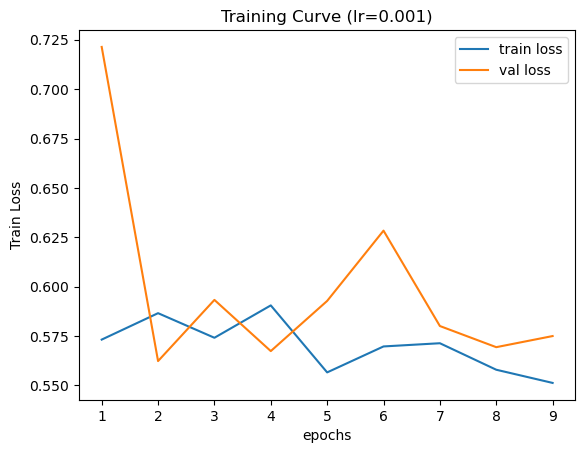

In [17]:
print("Plot of loss with epochs")
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

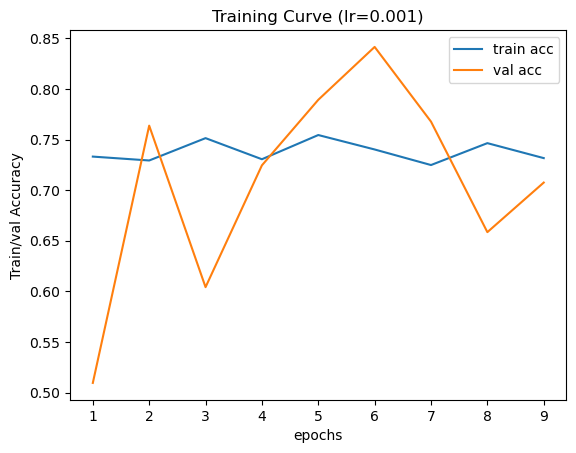

In [18]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train/val Accuracy")
plt.legend(loc="best")
plt.show()

In [12]:
!ls model-causal-model/

model_0_finetuned-35-epochs-lr_0.001.pth
model_1_finetuned-35-epochs-lr_0.001.pth
model_2_finetuned-30-epochs-lr_0.001.pth
model_3_finetuned-0-epochs-lr_0.001.pth
model_3_finetuned-1-epochs-lr_0.001.pth
model_3_finetuned--3-epochs-lr_0.001.pth
model_3_finetuned--4-epochs-lr_0.001.pth
model_3_finetuned-5-epochs-lr_0.001.pth
model_4_finetuned--5-epochs-lr_0.001.pth
model_4_finetuned--6-epochs-lr_0.001.pth


In [20]:
#ls ./model-causal-model/model_3_finetuned-5-epochs-lr_0.001.pth

./model-causal-model/model_3_finetuned-5-epochs-lr_0.001.pth


In [27]:
## saving the model 
# torch.save(model.state_dict(), "finetuned-35-epochs-1e3-lr-with-weighted-loss.pth") # early stopping saves model

### Load the model 
- if train and wants to evaluate: jsut use the `sameModelName`
- if want to laod a specific model - use next cell and write in double quote

In [107]:
# model_name = str(saveModelName)
# print(model_name)

./model-causal-model/model_3_finetuned-10-epochs-lr_0.001.pth


In [15]:
# model_name = early
model_name = "./model-causal-model/model_4_finetuned--6-epochs-lr_0.001.pth"


In [16]:
# loading the locally saved model

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CausalityBERT()
model.load_state_dict(torch.load(model_name))
## Move the model to the GPU 
model.to(device)
model.eval() # gettign in the eval mode 



You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.2.intermediate.dense.bias', 'roberta.encoder.layer.9.output.dense.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.encoder.layer.10.output.dense.bias', 'roberta.encoder.layer.3.attention.self.query.weight', 'roberta.encoder.layer.7.output.dense.bias', 'roberta.encoder.layer.4.attention.self.query.bias', 'roberta.encoder.layer.5.intermediate.dense.weight', 'roberta.encoder.layer.6.intermediate.dense.bias', 'roberta.encoder.layer.2.attention.self.value.weight', 'roberta.encoder.layer.11.intermediate.dense.weight', 'roberta.encoder

CausalityBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True

## evaluation on the test dataset 



In [19]:
#loss_fn = CrossEntropyLoss()
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []


for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader

    with torch.no_grad():
        model.eval()
        logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 
    
    # move logits and labels to CPU
    logits = logits.detach().to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    metrics = compute_metrics(pred_flat, labels_flat)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])

    
print(F'\n\ttest loss: {np.mean(test_loss)}')
print(F'\n\ttest acc: {np.mean(test_acc)}')
print(F'\n\ttest prec: {np.mean(test_prec)}')
print(F'\n\ttest rec: {np.mean(test_rec)}')
print(F'\n\ttest f1: {np.mean(test_f1)}')





  0%|          | 0/77 [00:00<?, ?it/s]<ipython-input-8-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  1%|▏         | 1/77 [00:01<01:26,  1.14s/it]<ipython-input-8-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  3%|▎         | 2/77 [00:02<01:25,  1.14s/it]<ipython-input-8-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  4%|▍         | 3/77 [00:03<01:24,  1.14s/it]<ipython


	test loss: nan

	test acc: 0.5082328385899815

	test prec: 0.20293418702509614

	test rec: 0.8393939393939395

	test f1: 0.3122470532697302



/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Print predictions of last test set batch:

In [20]:
# take last batch of test set:

for i in range(len(batch)):
    tokens = tokenizer.convert_ids_to_tokens(b_input_ids[i])
    print("\nPadded Sentence:")
    print(tokens)
    print("prediction:", pred_flat[i])
    


Padded Sentence:
['<s>', 'She', 'is', 'one', 'of', 'our', 'Dia@@', 'betic', 'patients', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
prediction: 0

Padded Sentence:
['<s>', 'Instead', 'of', 'drinking', 'the', 'nasty', 'gluc@@', 'ose', 'drink', 'when', 'you', "'", 're', 'pregnant', ',', 'they', 'should', 'offer', 'another', 'option', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',